# Exercise 09
## Lars Kühmichel, Nicolas Wolf

In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import time

In [2]:
plt.rc("figure", dpi=150)
plt.rc("legend", fontsize=6)

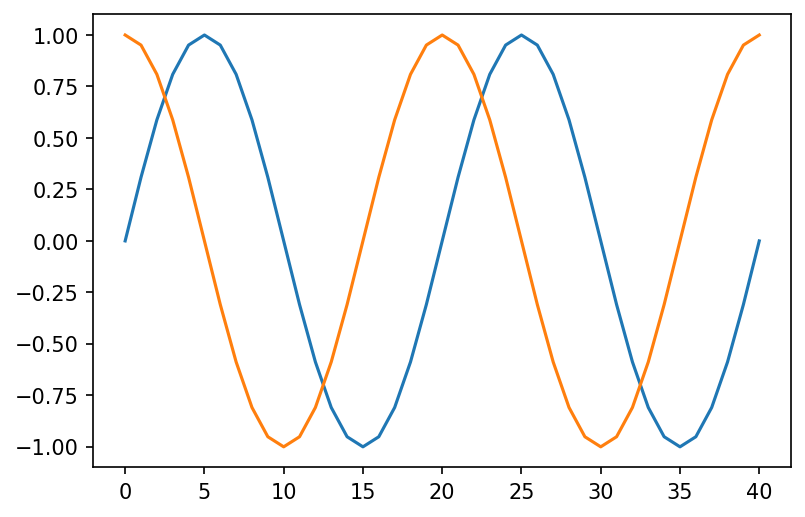

In [3]:
data = torch.load('sinus.pt')
observation_size = data.shape[1]

plt.plot(data)
#plt.savefig('inputData', dpi=500)
#plt.close()
plt.show()

## Task 2: Training an RNN with PyTorch, Task 4: Mini-batching

In [105]:
class latent_RNN(nn.Module):
    def __init__(self, obs_dim, latent_dim):
        super().__init__()
        self.obs_dim = obs_dim
        self.latent_dim = latent_dim
        
        self.U = nn.Parameter(torch.empty(size=(latent_dim, obs_dim)))
        self.V = nn.Parameter(torch.empty(size=(latent_dim, latent_dim)))
        self.bias_hidden = nn.Parameter(torch.empty(size=(latent_dim,)))
        self.bias_output = nn.Parameter(torch.empty(size=(obs_dim,)))
        
        k = np.sqrt(1/latent_dim)
        for p in self.parameters():
            nn.init.uniform_(p, -k, k)

        self.W = nn.Parameter(torch.empty(size=(obs_dim, latent_dim)))
        nn.init.uniform_(self.W, -1/k, 1/k)
        

    def forward(self, time_series, h0):
        T = time_series.shape[0]
        # time_series.shape == (T, batch_size, observation_size)
        # h0.shape == (batch_size, hidden_size)
        
        x = torch.zeros(size=time_series.shape)
        h = h0
        for t in range(T):
            h = torch.tanh(time_series[t] @ self.U.T + h @ self.V.T + self.bias_hidden)
            x[t] = h @ self.W.T + self.bias_output
            
        return x, h
        
        
def train(model, optimizer, loss_function, epochs, hidden_size, batch_size=None):
    losses = np.zeros(epochs)
    
    pbar = tqdm(range(epochs))
    for i in pbar:
        h0 = torch.randn((1, hidden_size))
        x = data[:-1]  #x_0:T-1
        y = data[1:]   #x_1:T
                
        if batch_size is not None and 1 <= batch_size < len(x):
            num_batches = len(data) // batch_size
            start_indices = np.random.randint(0, len(x)-batch_size, num_batches)
            x_batches = torch.zeros(size=(batch_size, num_batches, observation_size))
            y_batches = torch.zeros(size=(batch_size, num_batches, observation_size))
            for j, index in enumerate(start_indices):
                x_batches[:,j,:] = x[index:index+batch_size]
                y_batches[:,j,:] = y[index:index+batch_size]
            x = x_batches
            y = y_batches
            
            
        optimizer.zero_grad()               
        output, _ = model(x, h0)
        epoch_loss = loss_function(output, y)
        epoch_loss.backward()
        optimizer.step()
        
        losses[i] = epoch_loss.item()
        if i % 10 == 0:
            pbar.set_description(f"loss = {epoch_loss.item():.5f}")
            
    return losses

In [44]:
hidden_size = 20
epochs = 500

learning_rate = 0.001


model = latent_RNN(observation_size, hidden_size)

# TASK 3: Change the parameters of the optimizer, and replace SGD by Adam
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
loss_function = nn.MSELoss()

train(model, optimizer, loss_function, epochs, hidden_size)


  0%|          | 0/500 [00:00<?, ?it/s]

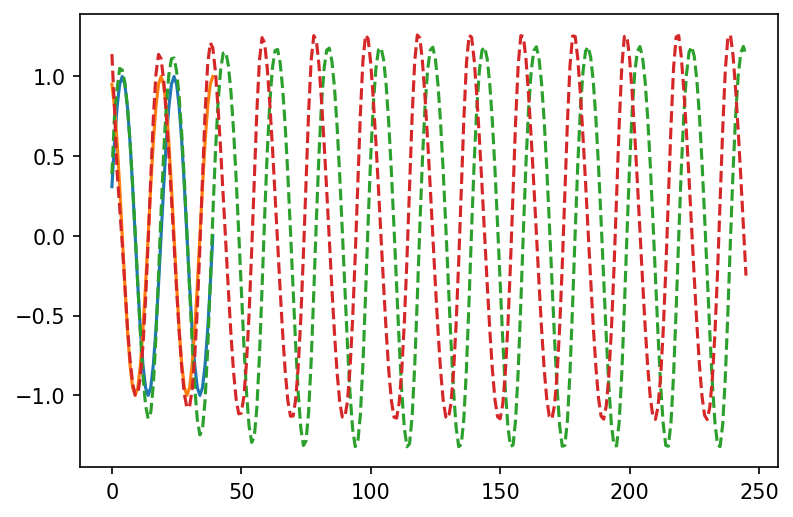

In [45]:
with torch.no_grad():
    h = torch.zeros((1, hidden_size))
    predictions = torch.zeros((6*data.shape[0], observation_size))
    input_ = data[0:1]
    for i in range(6*data.size(0)):
        pred, h = model(input_, h)
        input_ = pred
        predictions[i] = pred
    
    plt.figure()
    plt.plot(data[1:])
    plt.plot(predictions, "--")
    #plt.xlim((0, 50))
    plt.show()
    #plt.savefig('Predictions', dpi=500)
    

  0%|          | 0/500 [00:00<?, ?it/s]

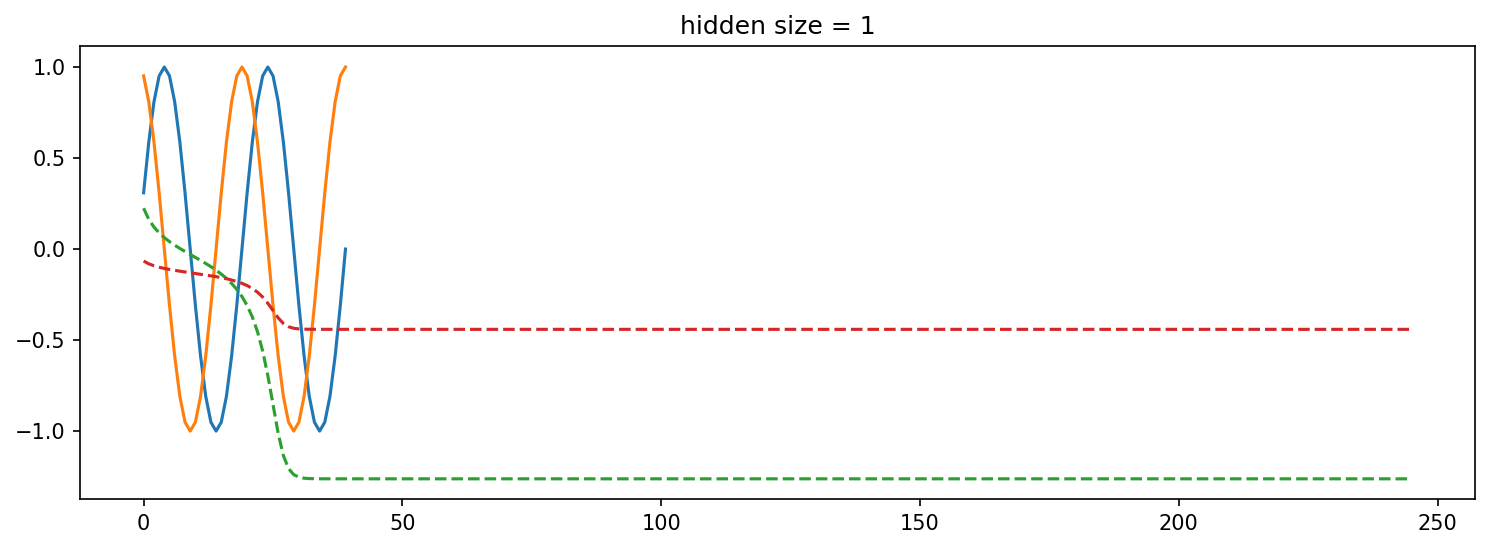

  0%|          | 0/500 [00:00<?, ?it/s]

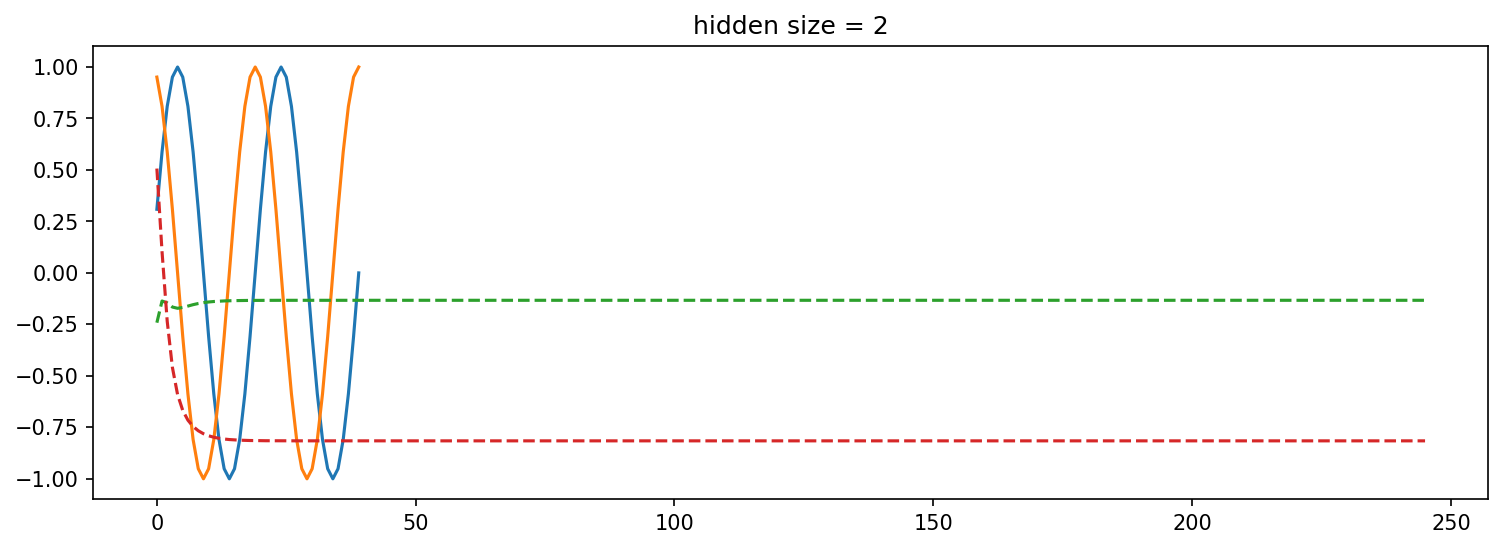

  0%|          | 0/500 [00:00<?, ?it/s]

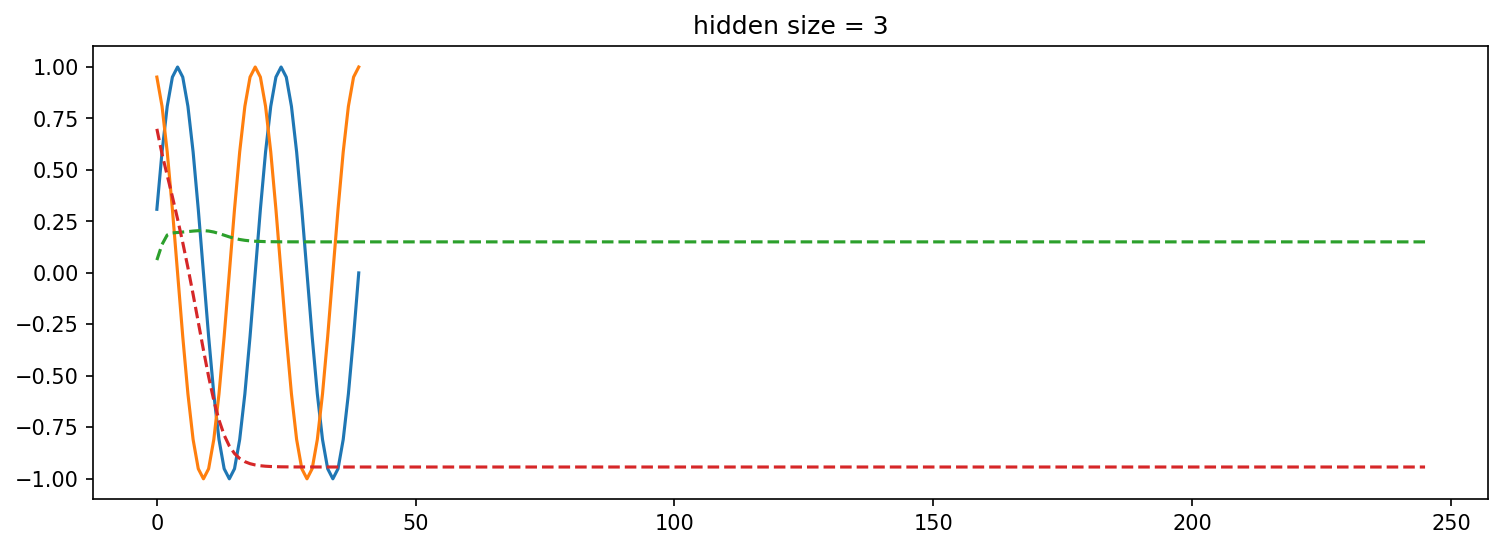

  0%|          | 0/500 [00:00<?, ?it/s]

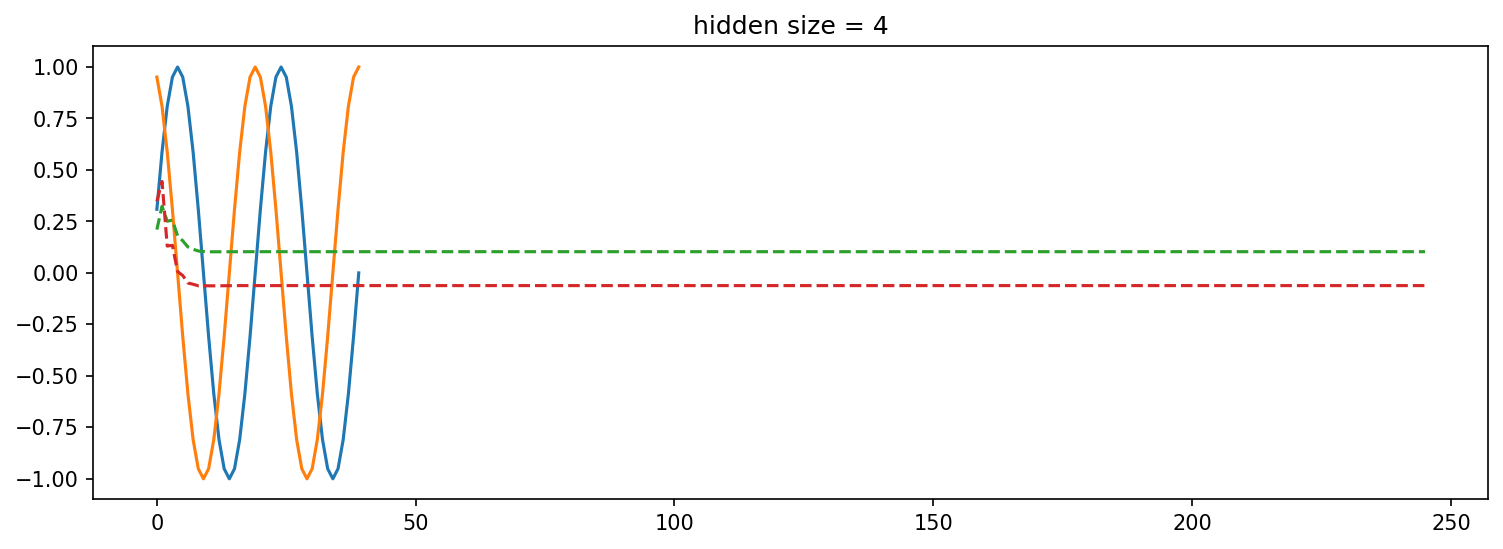

  0%|          | 0/500 [00:00<?, ?it/s]

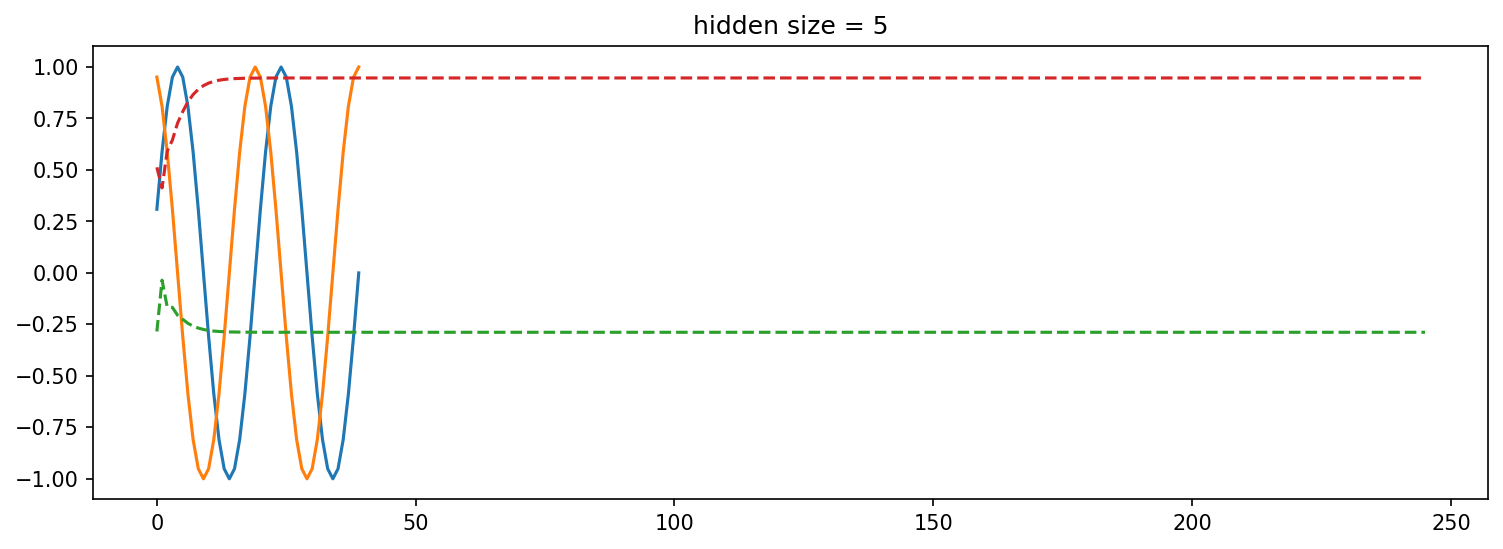

  0%|          | 0/500 [00:00<?, ?it/s]

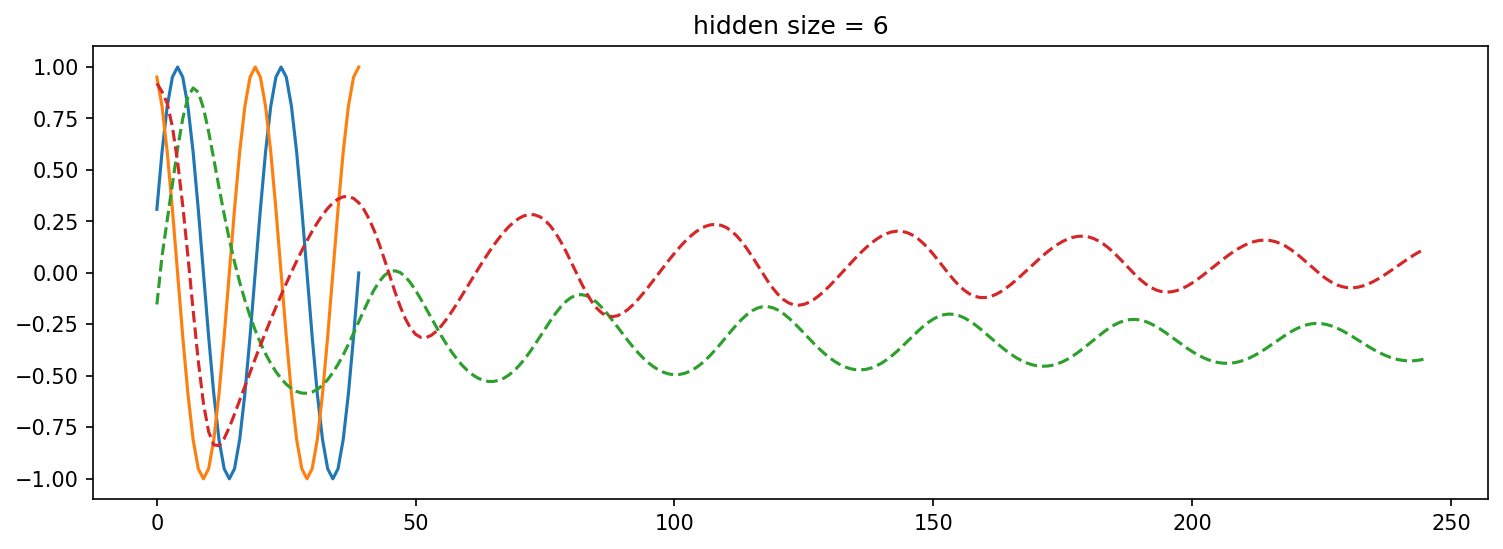

  0%|          | 0/500 [00:00<?, ?it/s]

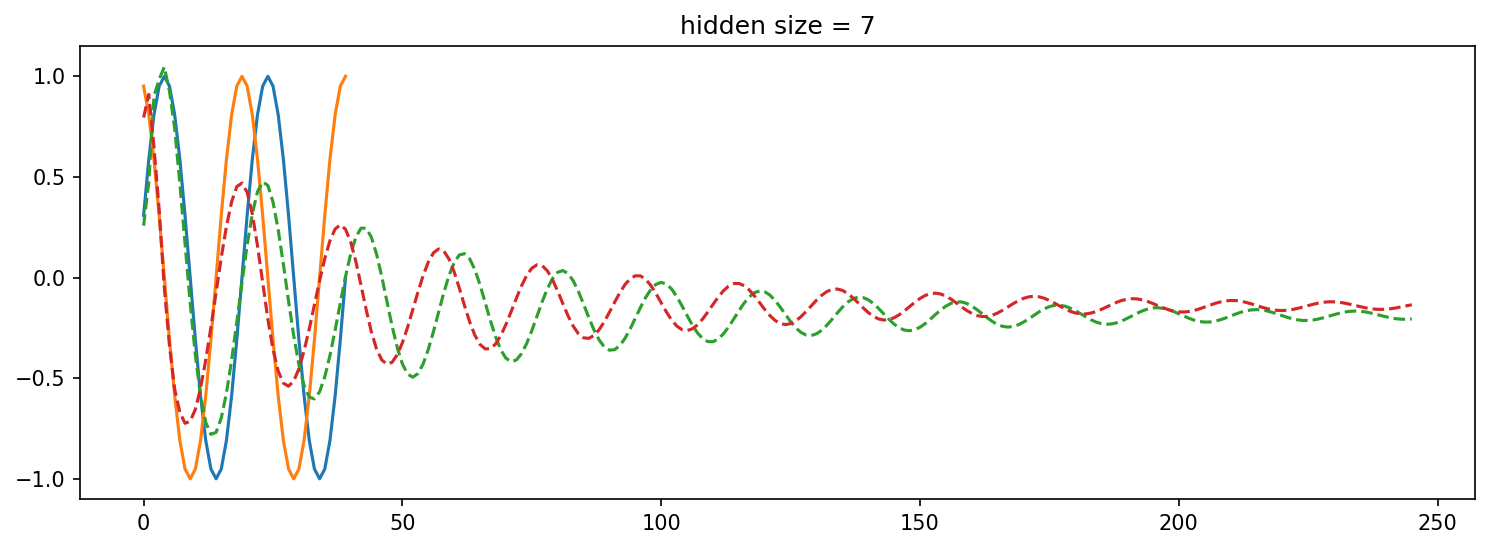

  0%|          | 0/500 [00:00<?, ?it/s]

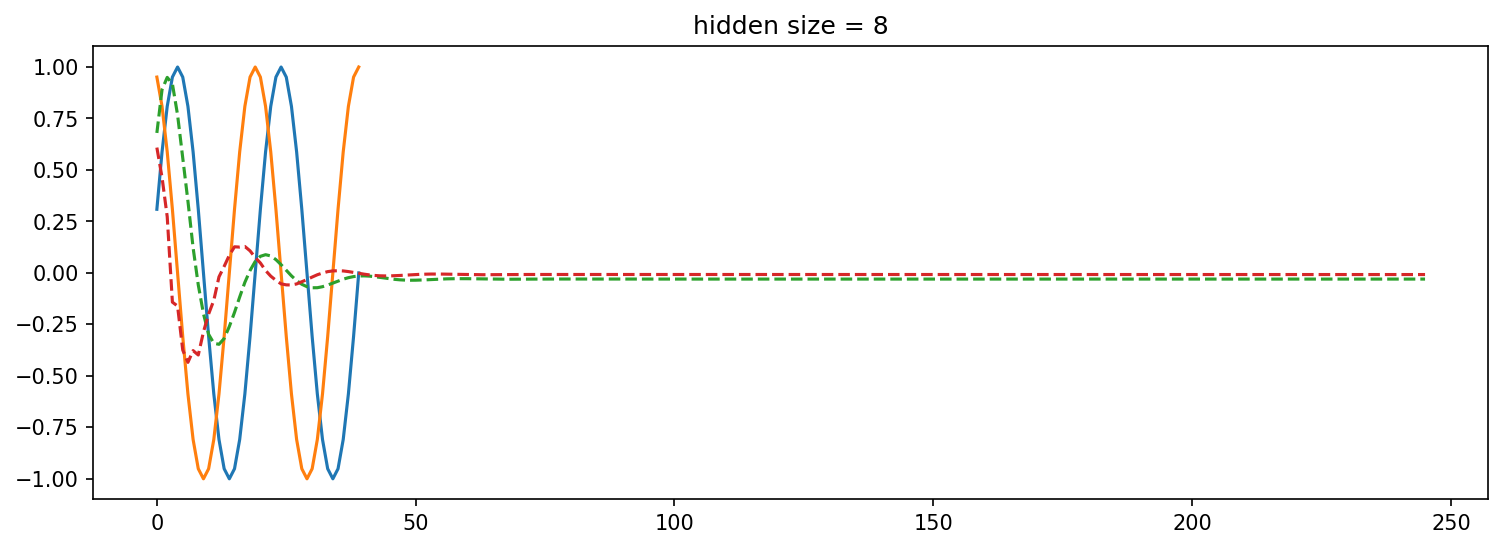

  0%|          | 0/500 [00:00<?, ?it/s]

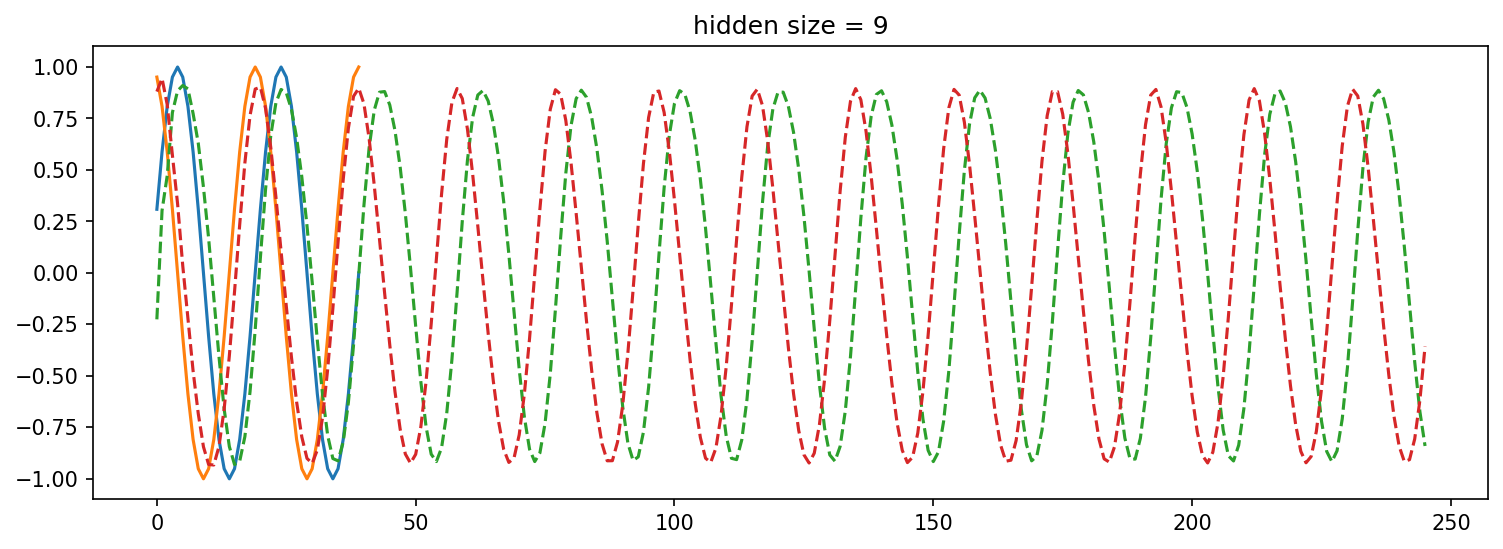

  0%|          | 0/500 [00:00<?, ?it/s]

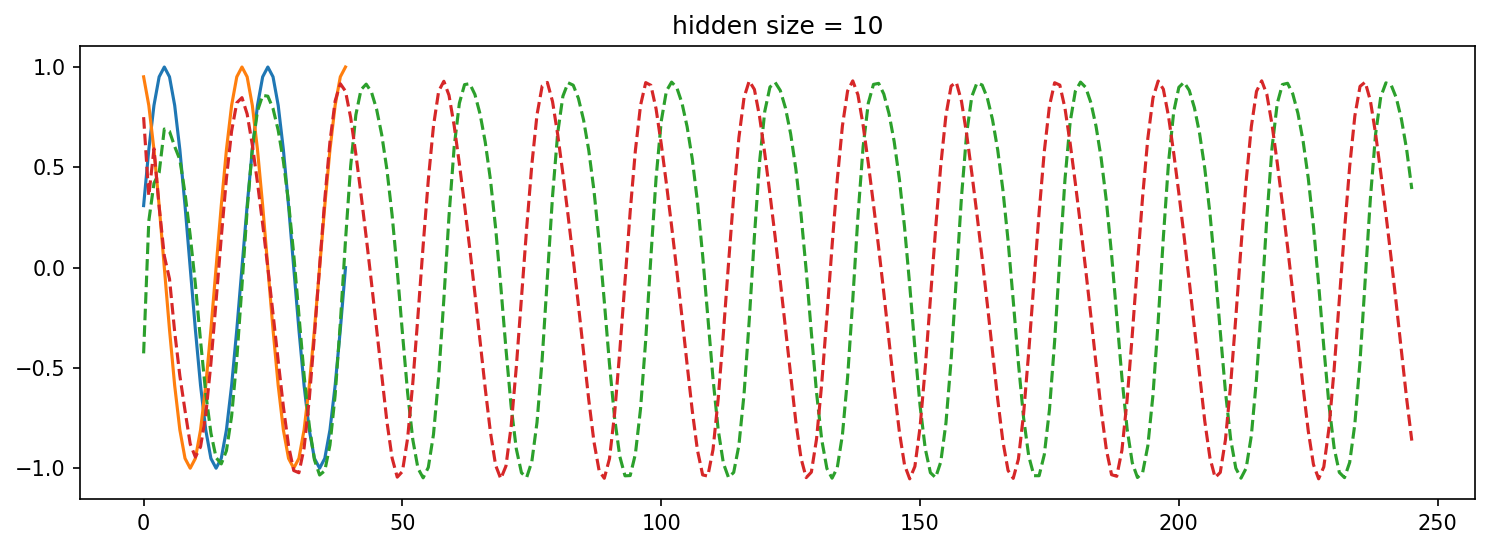

In [40]:
def find_minimal_hidden_size():
    epochs = 500
    learning_rate = 0.001
    
    hidden_sizes = np.arange(1, 10+1)
    for hidden_size in hidden_sizes:
        model = latent_RNN(observation_size, hidden_size)
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
        loss_function = nn.MSELoss()
        
        train(model, optimizer, loss_function, epochs, hidden_size)
        
        
        with torch.no_grad():
            h = torch.zeros((1, hidden_size))
            predictions = torch.zeros((6*data.shape[0], observation_size))
            input_ = data[0:1]
            for i in range(6*data.size(0)):
                pred, h = model(input_, h)
                input_ = pred
                predictions[i] = pred

            plt.figure(figsize=(12,4))
            plt.plot(data[1:])
            plt.plot(predictions, "--")
            #plt.xlim((0, 50))
            plt.title(f"hidden size = {hidden_size}")
            plt.show()
            #plt.savefig('Predictions', dpi=500)

find_minimal_hidden_size()

The RNN starts to learn oscillations with 6 hidden units, but it needs at least 9 hidden units to learn the full dynamics.

## Task 3

### 1. Plot losses as function of gradient steps, vary learning rate

  0%|          | 0/500 [00:00<?, ?it/s]

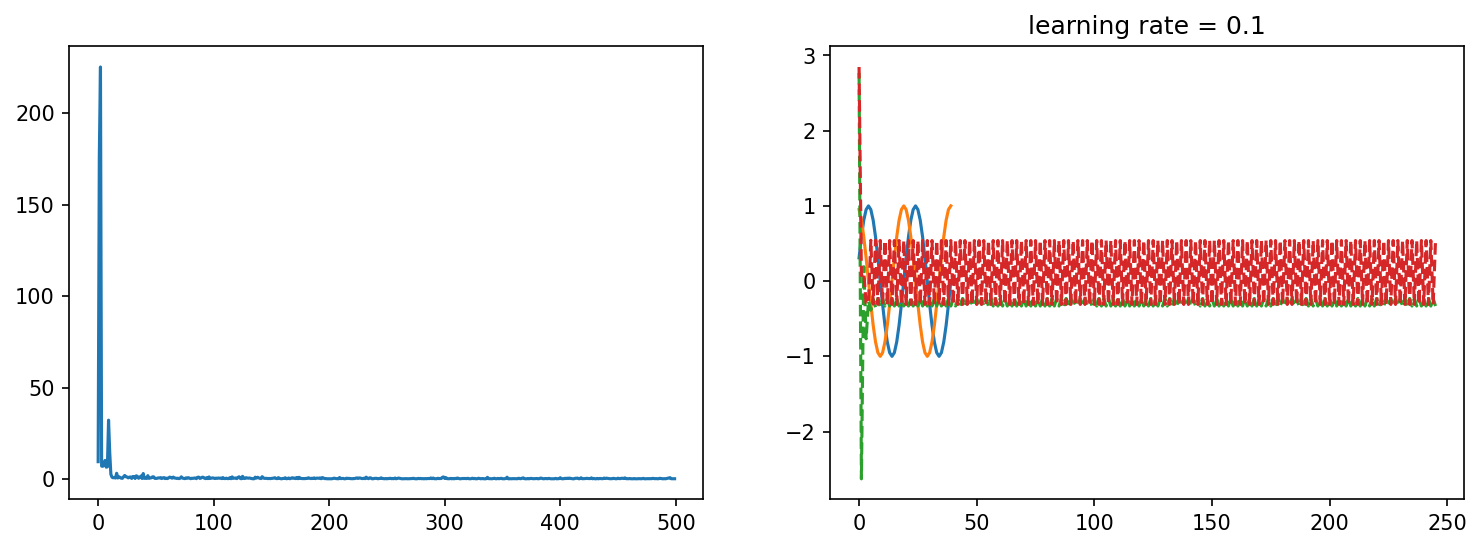

  0%|          | 0/500 [00:00<?, ?it/s]

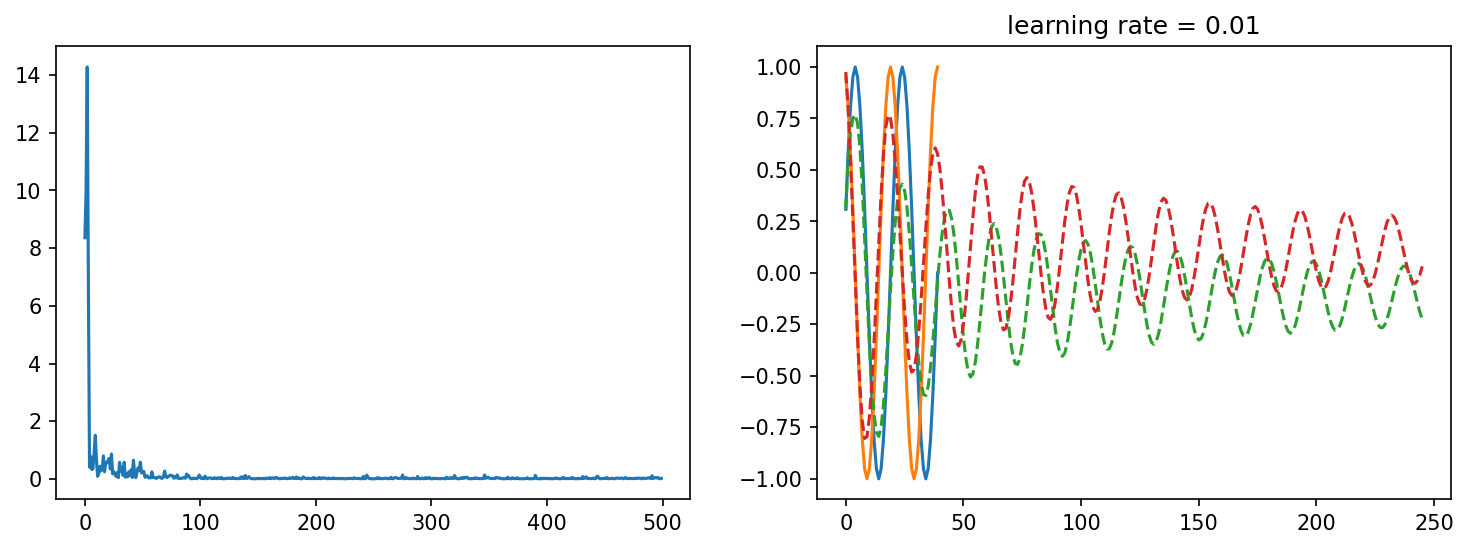

  0%|          | 0/500 [00:00<?, ?it/s]

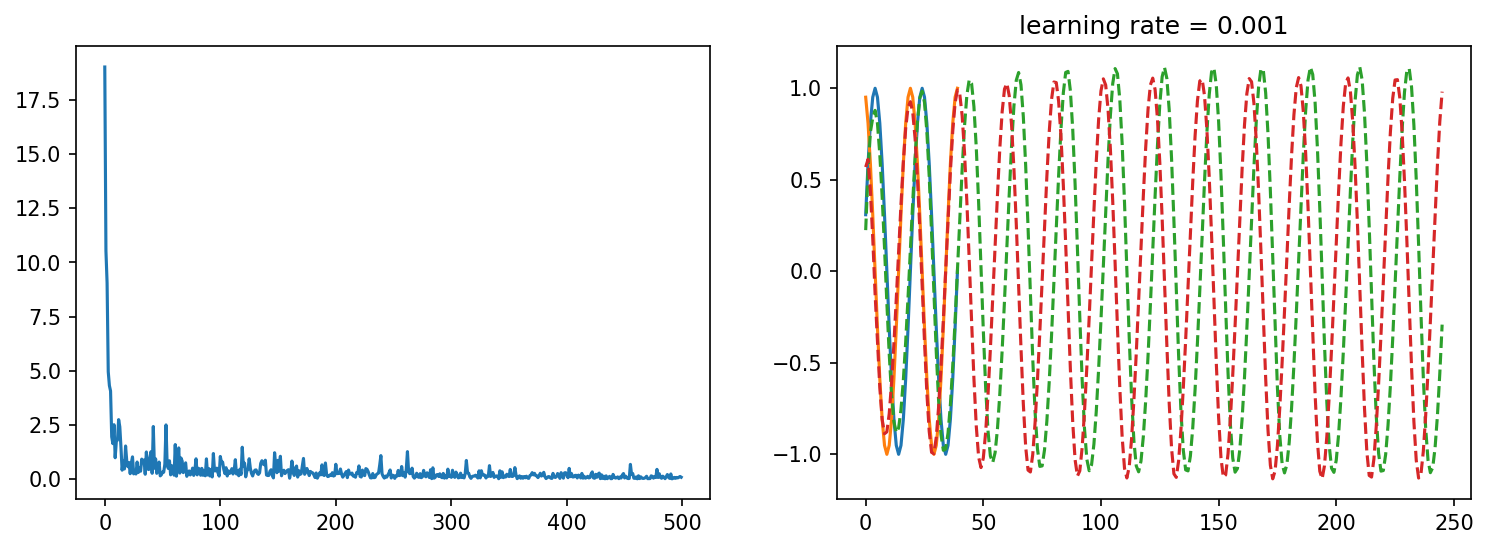

  0%|          | 0/500 [00:00<?, ?it/s]

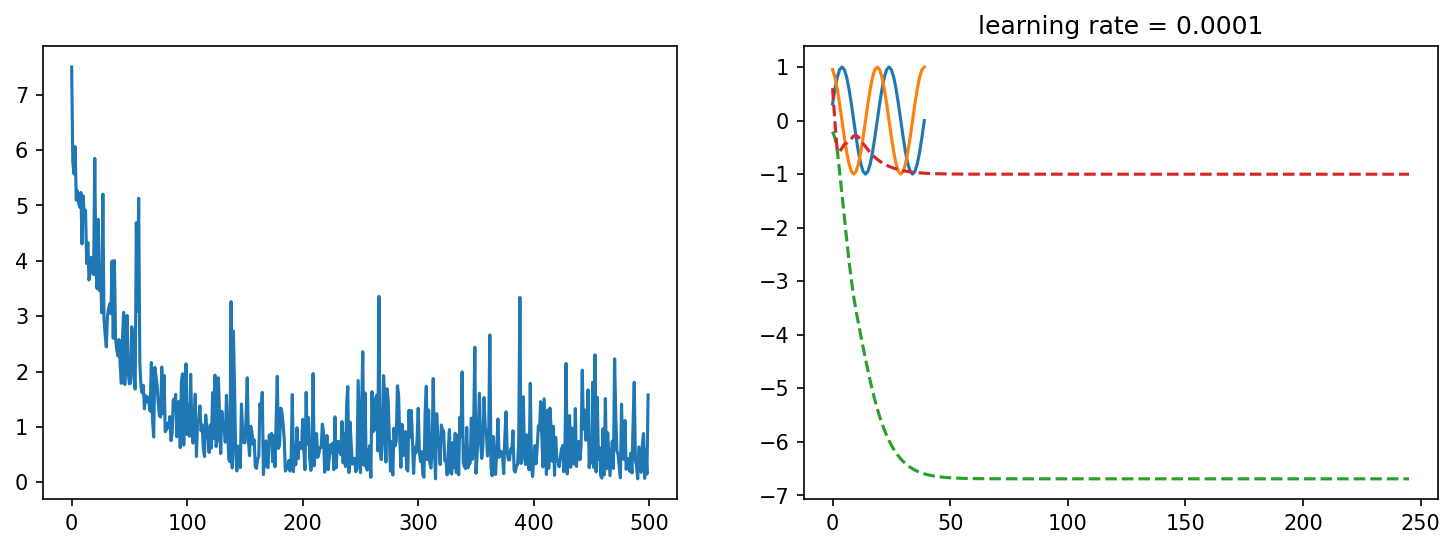

  0%|          | 0/500 [00:00<?, ?it/s]

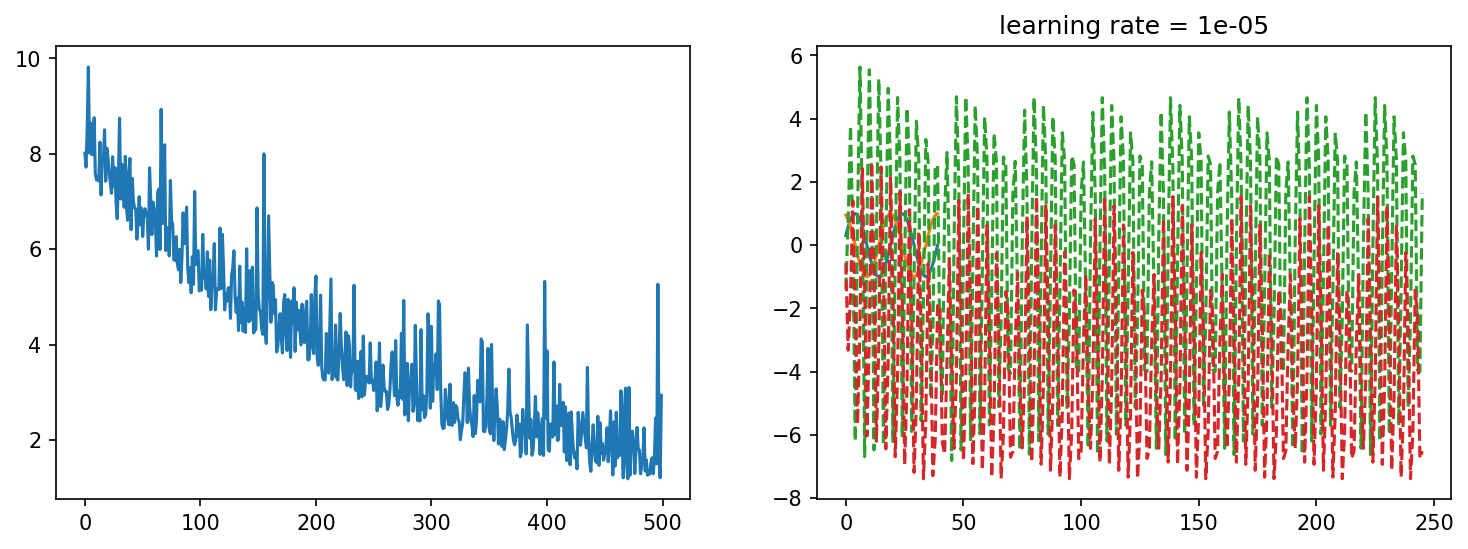

In [85]:
hidden_size = 20
epochs = 500
learning_rates = np.logspace(-1, -5, 5)
for lr in learning_rates:
    model = latent_RNN(observation_size, hidden_size)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0)
    loss_function = nn.MSELoss()

    losses = train(model, optimizer, loss_function, epochs, hidden_size)

    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    axes[0].plot(losses)
    
    with torch.no_grad():
        h = torch.zeros((1, hidden_size))
        predictions = torch.zeros((6*data.shape[0], observation_size))
        input_ = data[0:1]
        for i in range(6*data.size(0)):
            pred, h = model(input_, h)
            input_ = pred
            predictions[i] = pred

        axes[1].plot(data[1:])
        axes[1].plot(predictions, "--")

    plt.title(f"learning rate = {lr}")
        
    plt.show()

If the learning rate is too large, the loss decreases very fast, but does not reach the optimum. 
If the learning rate is too small, the model would need more epochs to converge.
In both cases the model does not learn the dynamics.

The optimal learning rate is 0.001

### 2. How do the dynamics change when the leraning rate is adapted with momentum?

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

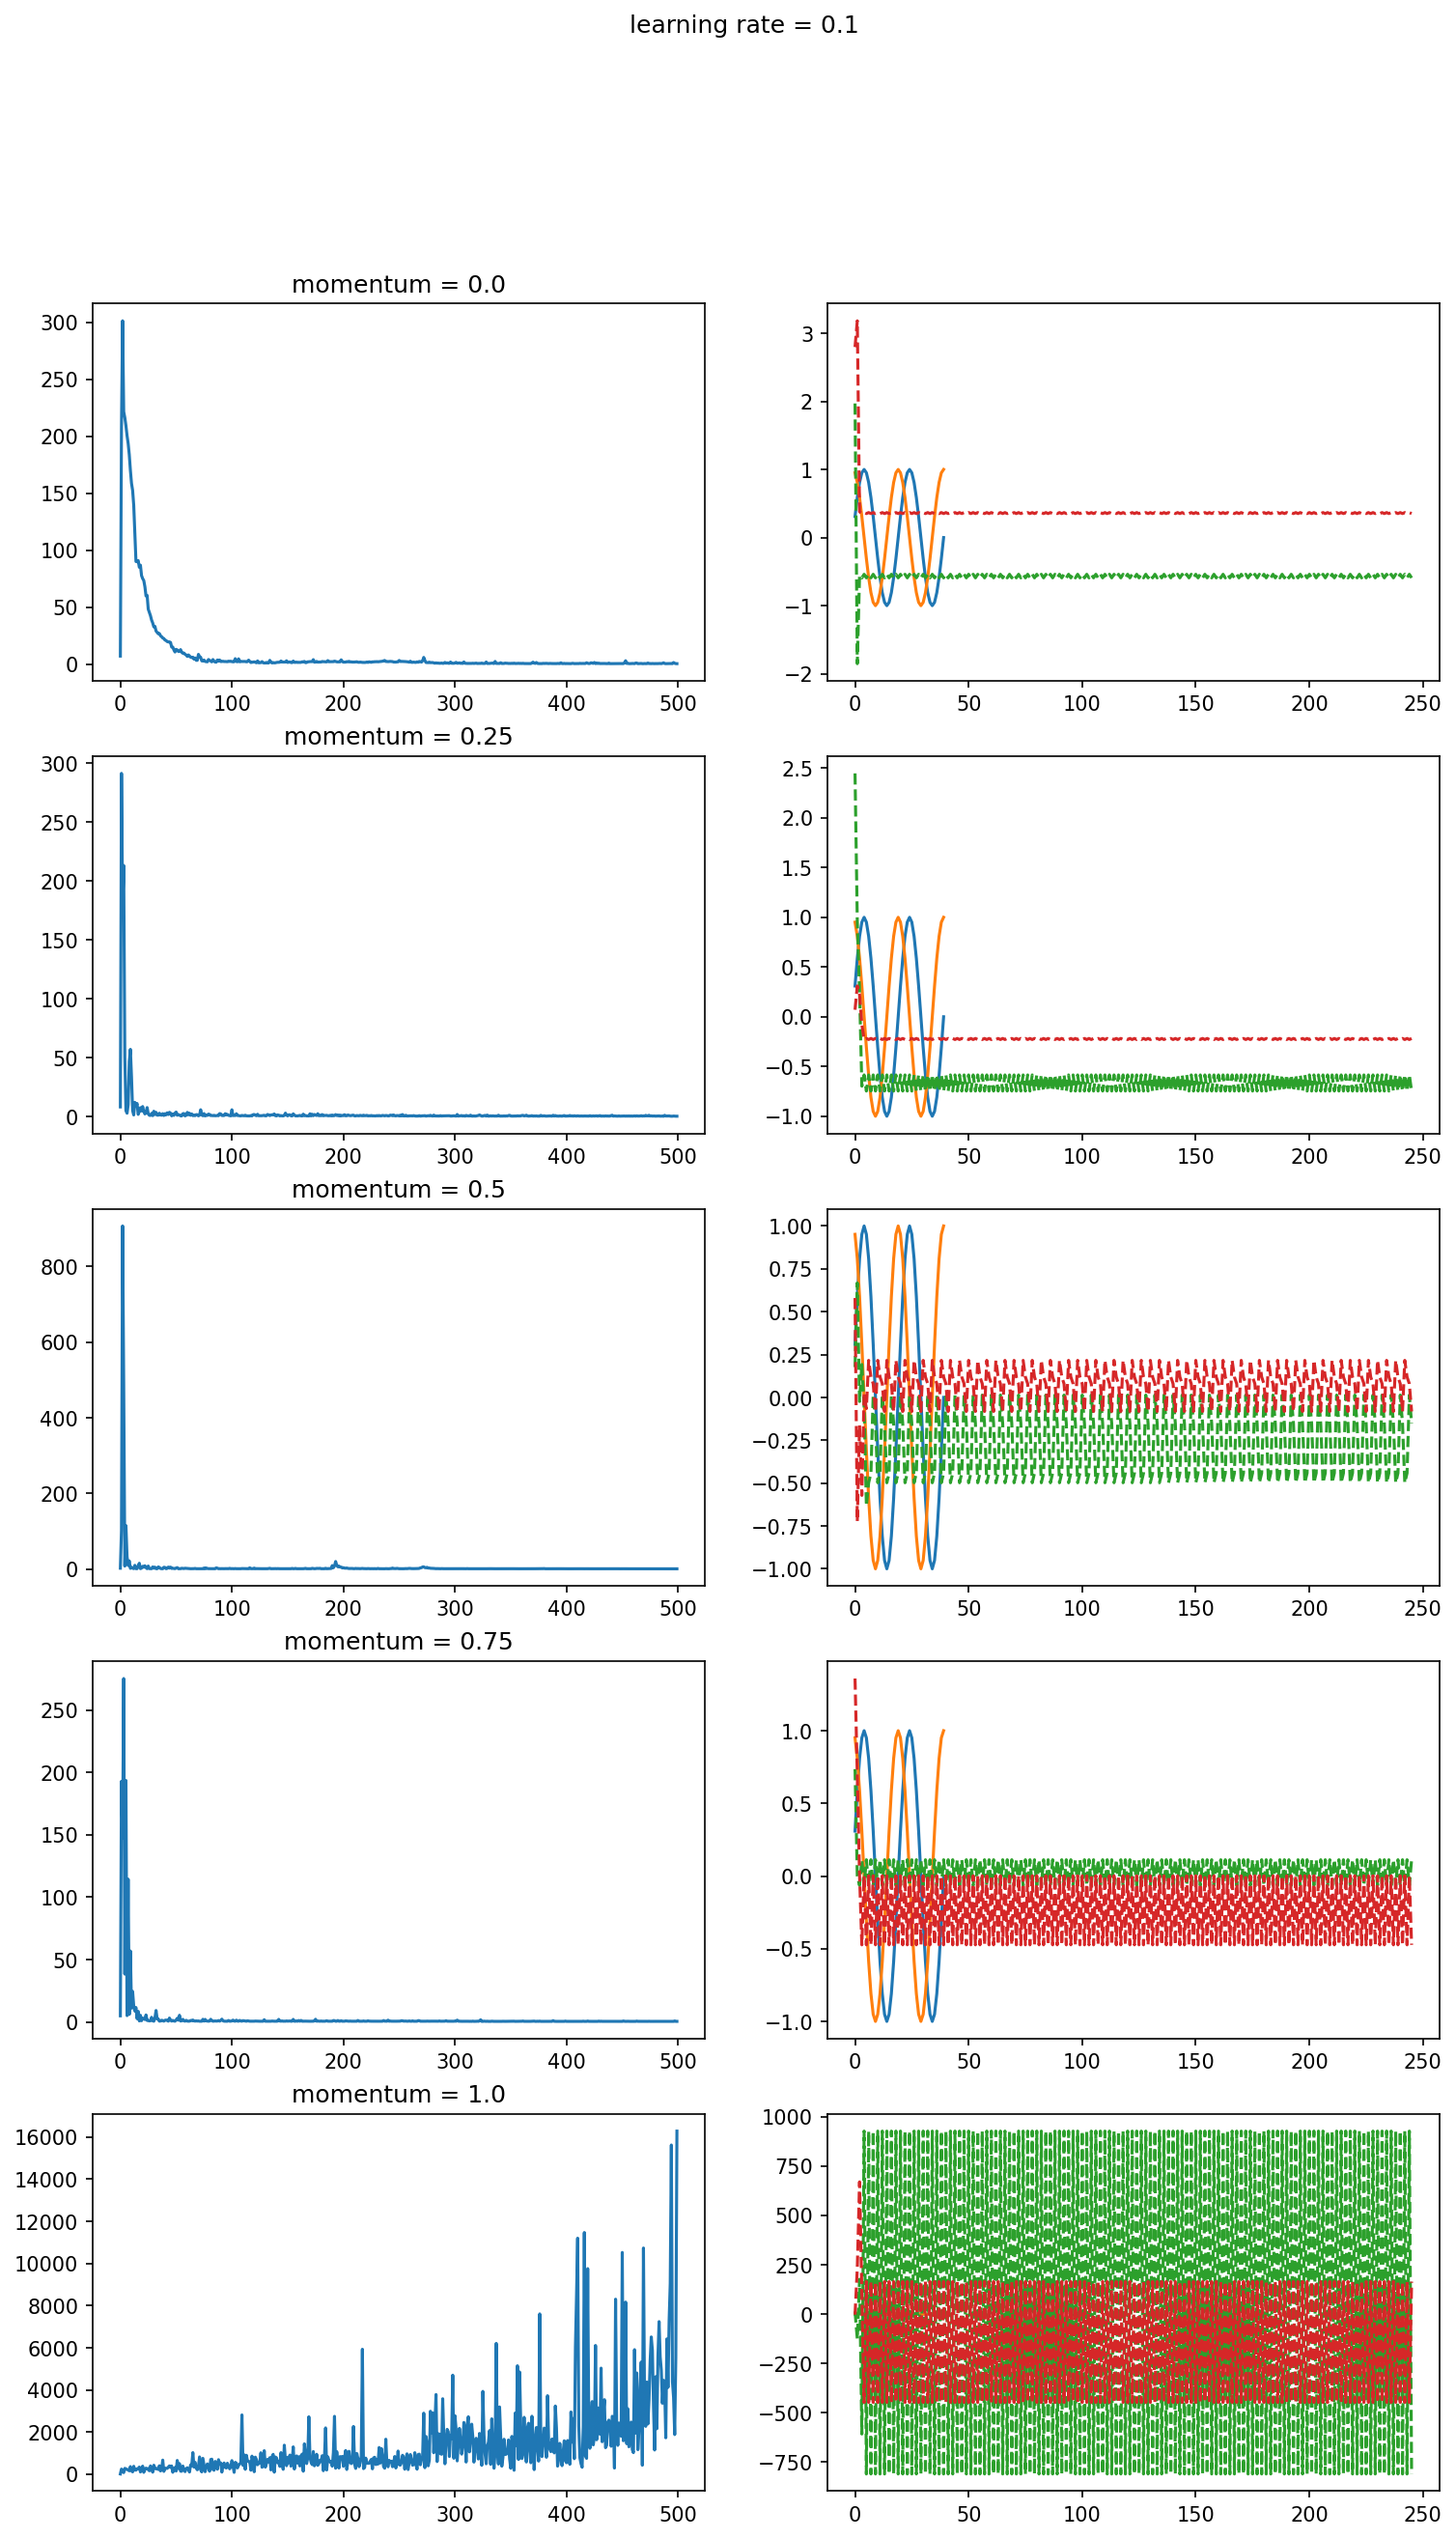

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

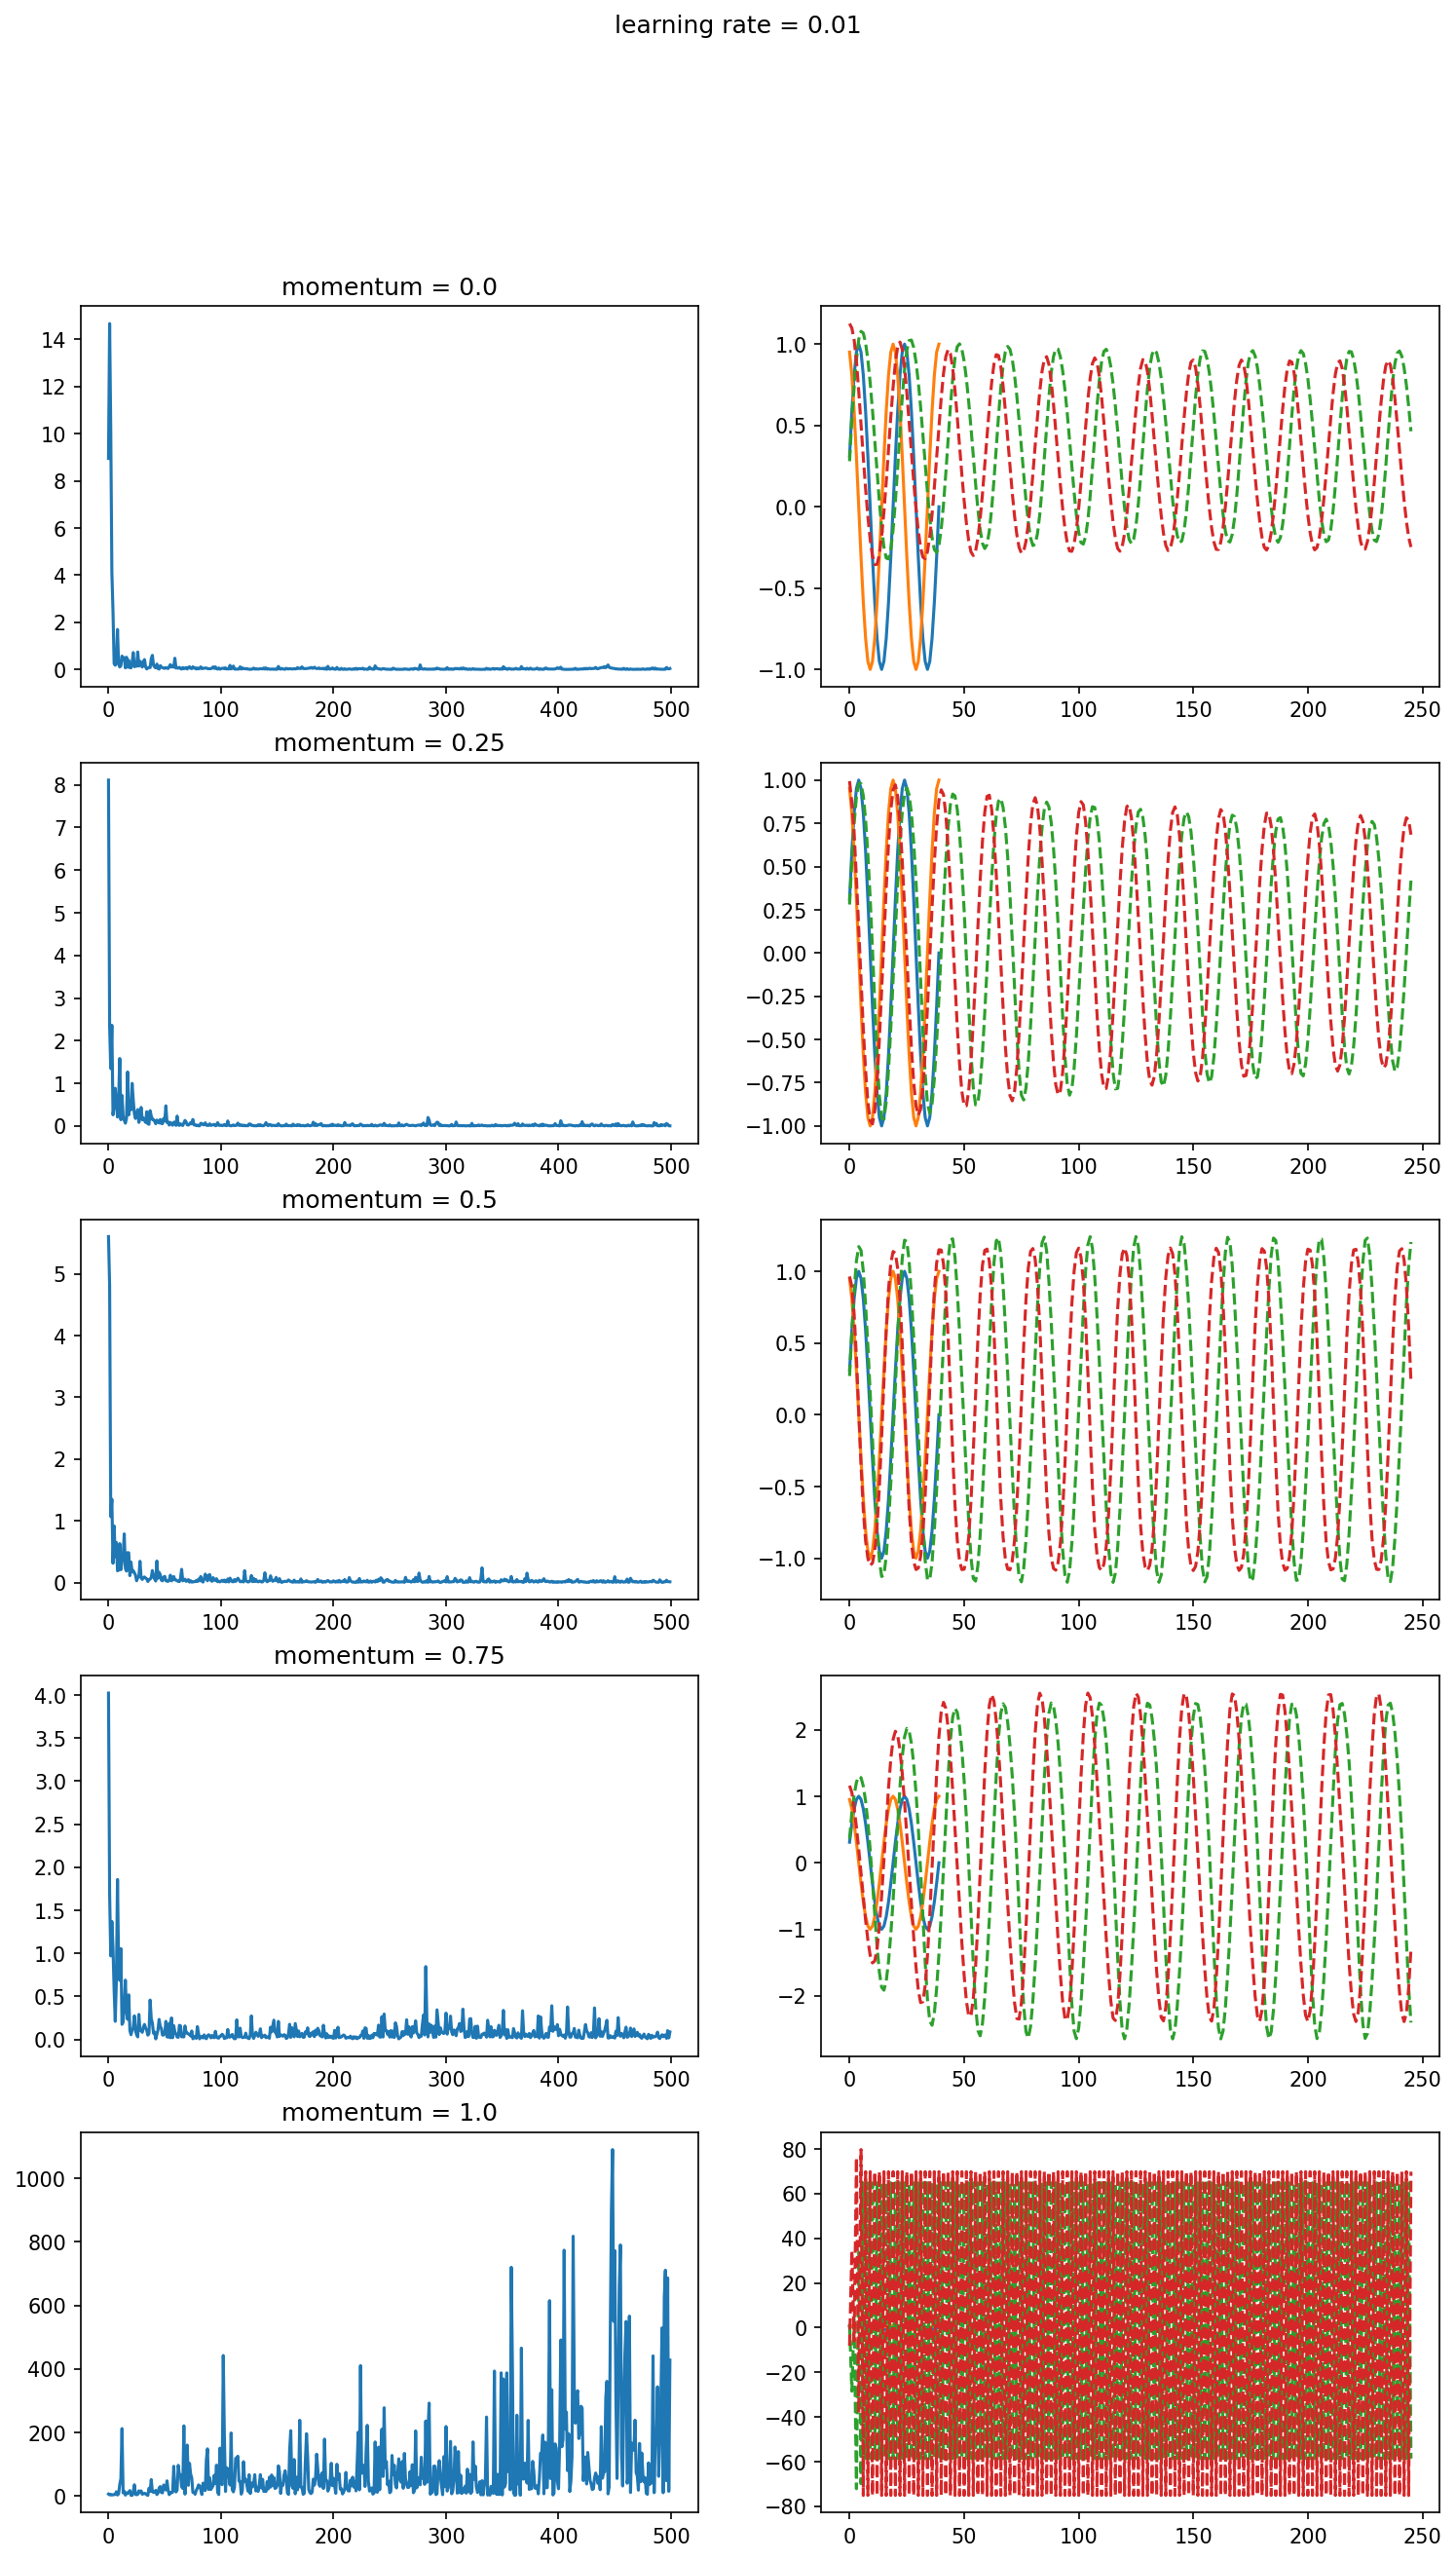

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

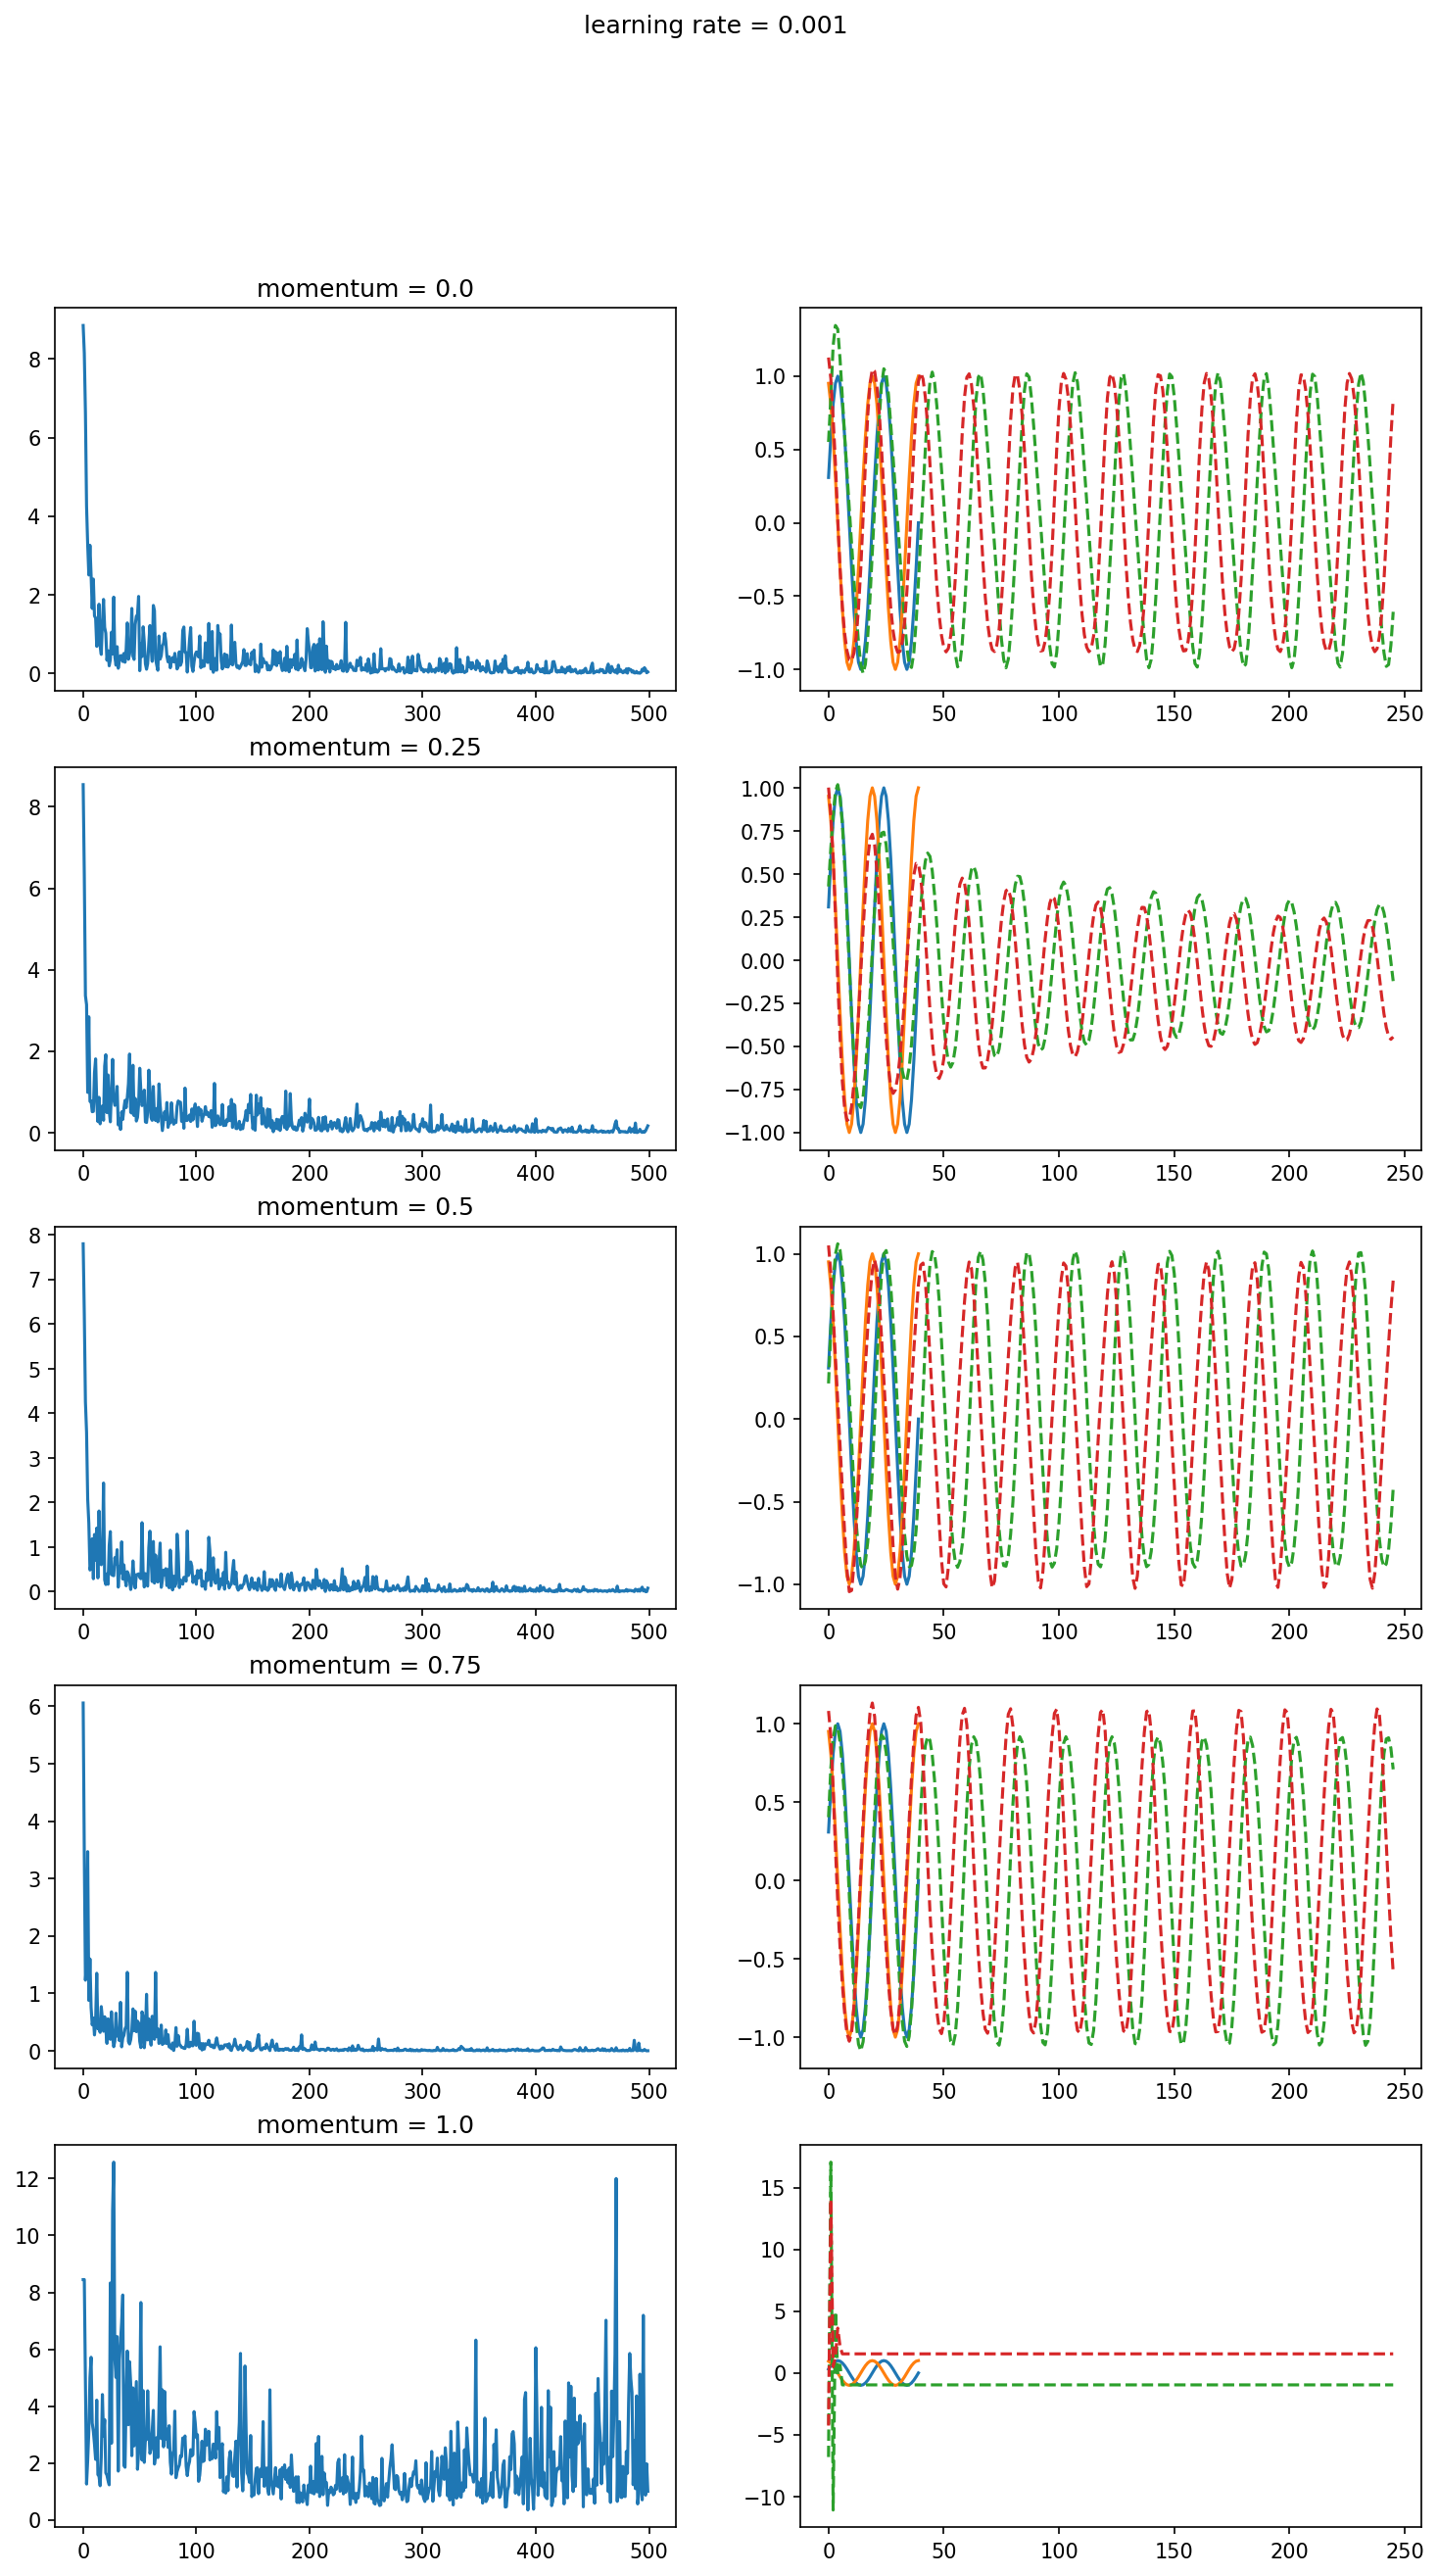

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

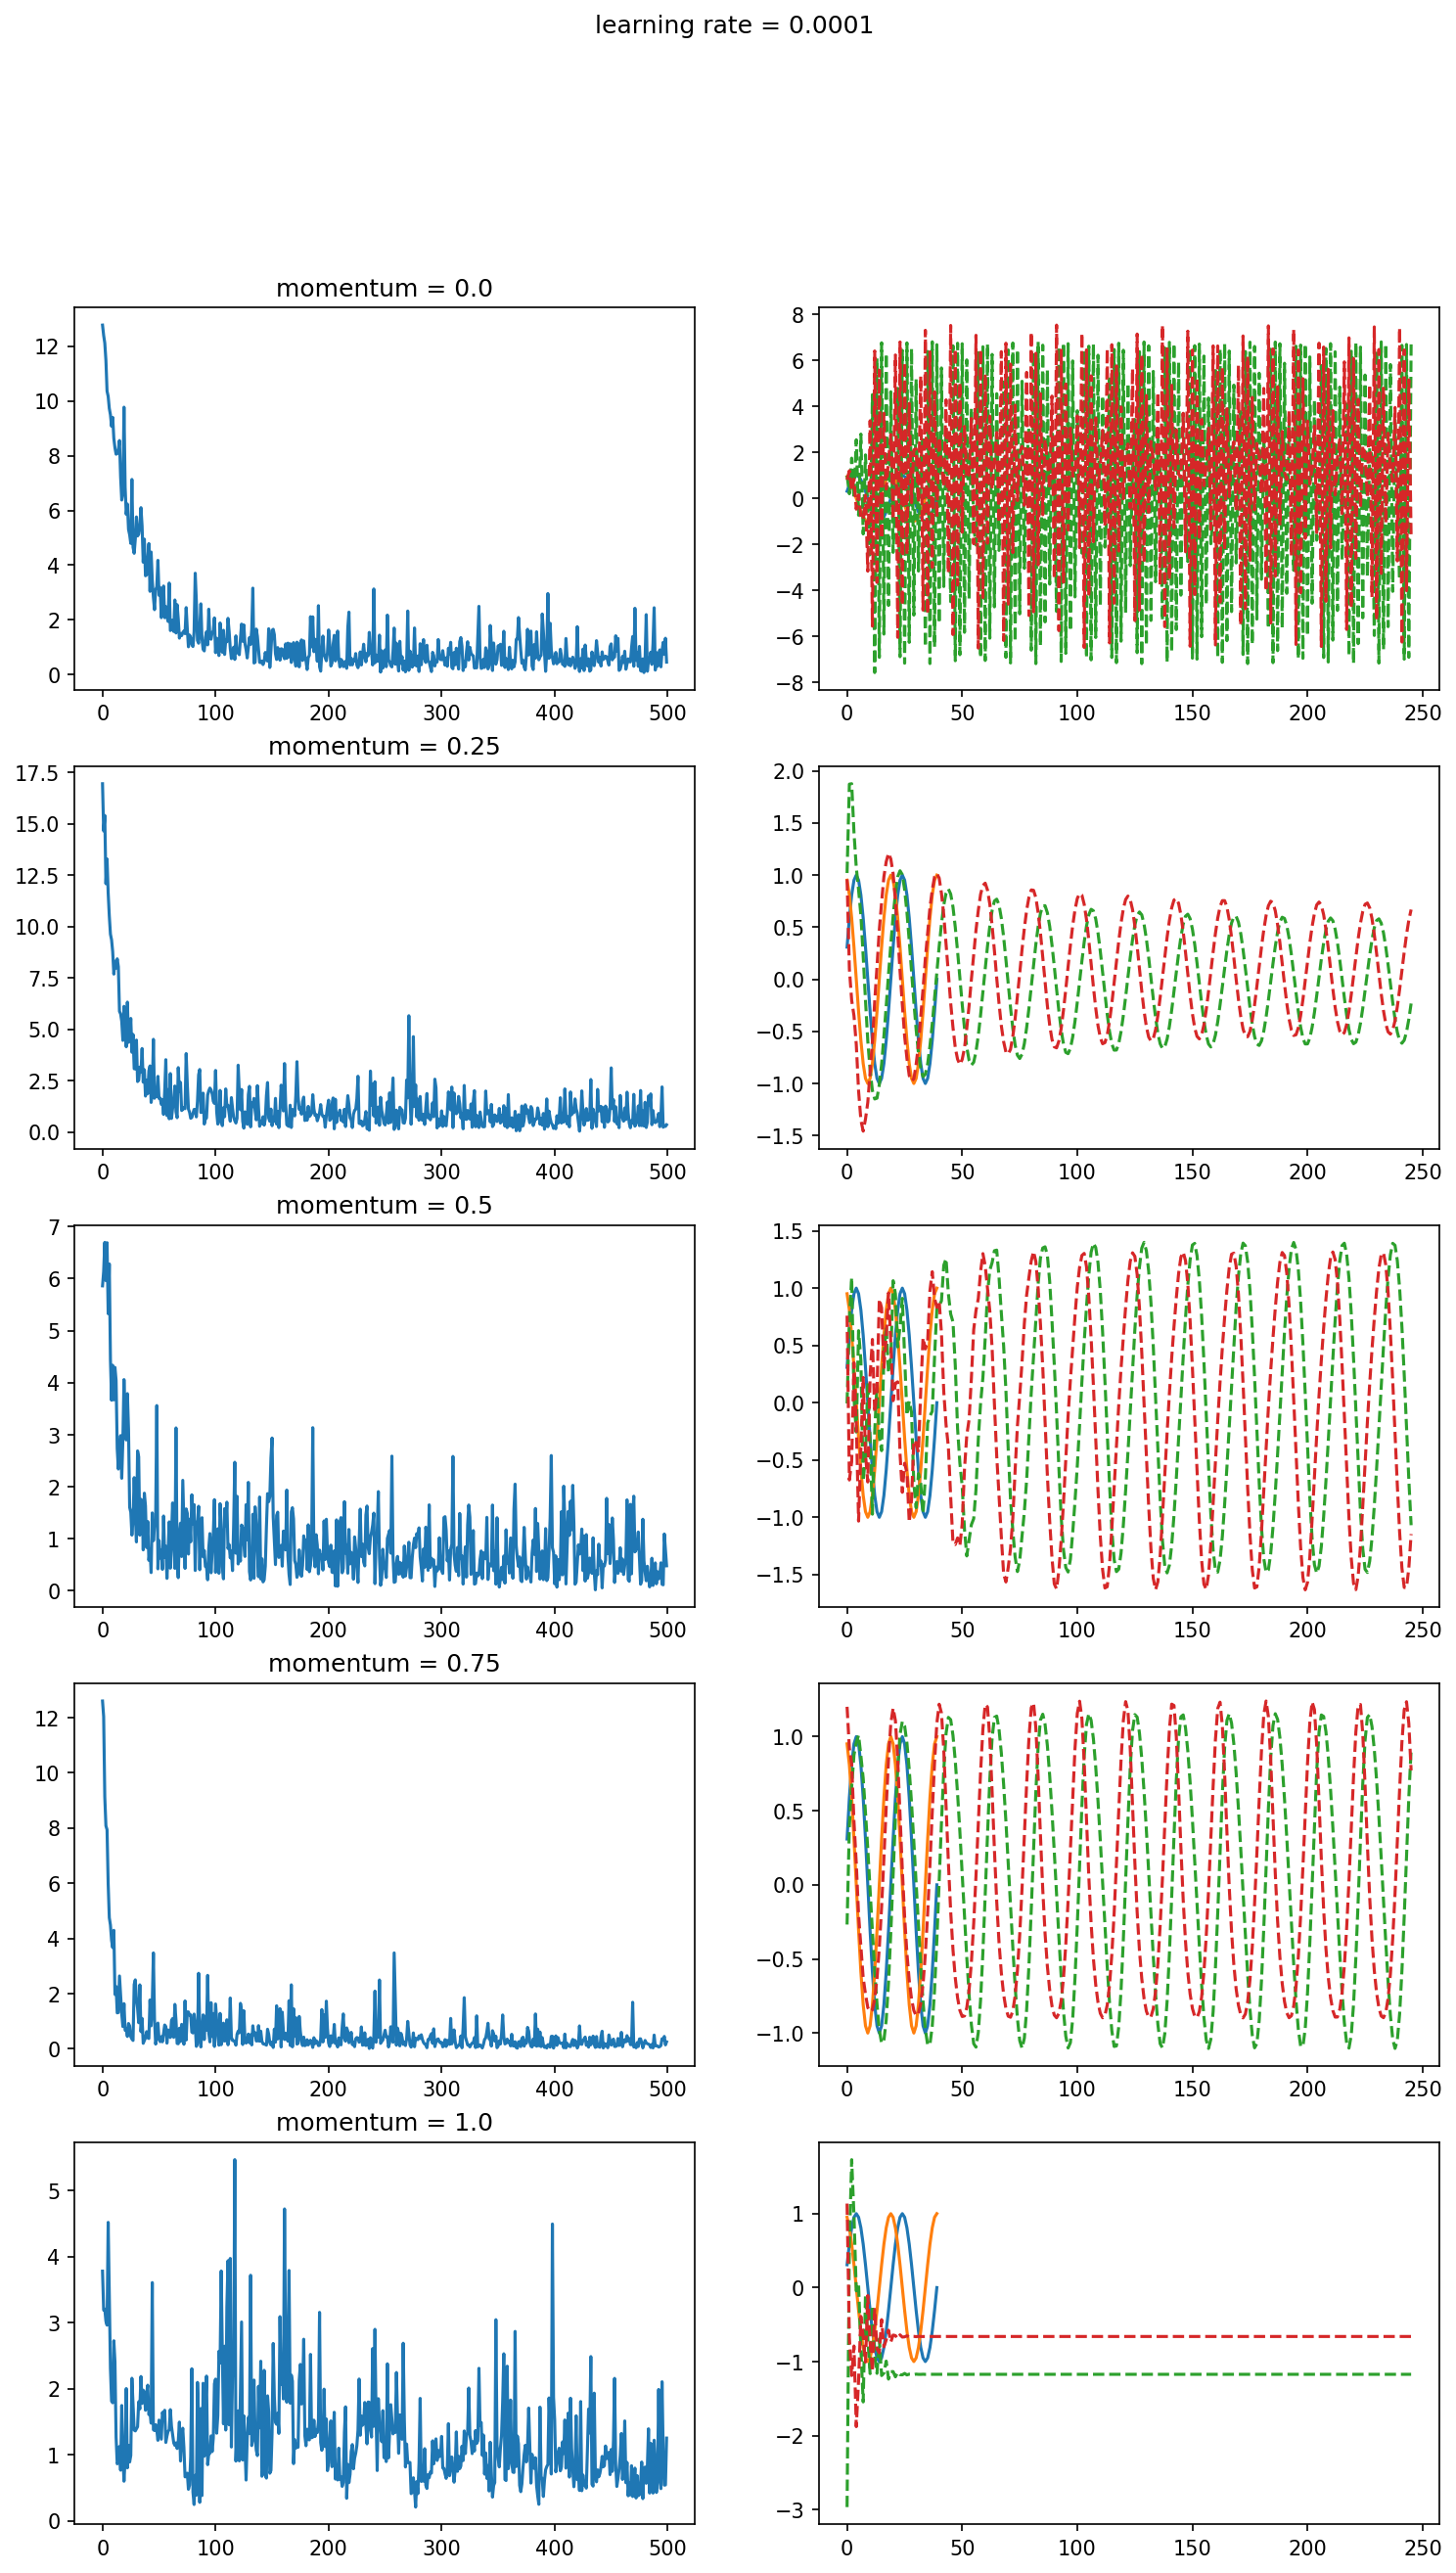

In [117]:
learning_rates = np.logspace(-1, -4, 4)
momenta = np.linspace(0, 1, 5)

hidden_size = 20
epochs = 500
for learning_rate in learning_rates:
    fig, axes = plt.subplots(len(momenta), 2, figsize=(12,4*len(momenta)))
    for j, momentum in enumerate(momenta):
        model = latent_RNN(observation_size, hidden_size)
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
        loss_function = nn.MSELoss()

        losses = train(model, optimizer, loss_function, epochs, hidden_size)

        axes[j, 0].plot(losses)

        with torch.no_grad():
            h = torch.zeros((1, hidden_size))
            predictions = torch.zeros((6*data.shape[0], observation_size))
            input_ = data[0:1]
            for i in range(6*data.size(0)):
                pred, h = model(input_, h)
                input_ = pred
                predictions[i] = pred

            axes[j, 1].plot(data[1:])
            axes[j, 1].plot(predictions, "--")
    
        axes[j, 0].set_title(f"momentum = {momentum}")

    fig.suptitle(f"learning rate = {learning_rate}")
    plt.show()

For all learning rates, a momentum of 0.5 or 0.75 seem to give slightly better results than with 0 momentum. In all cases, the model will not converge with a momentum of 1.

### 3. Adam vs SGD

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

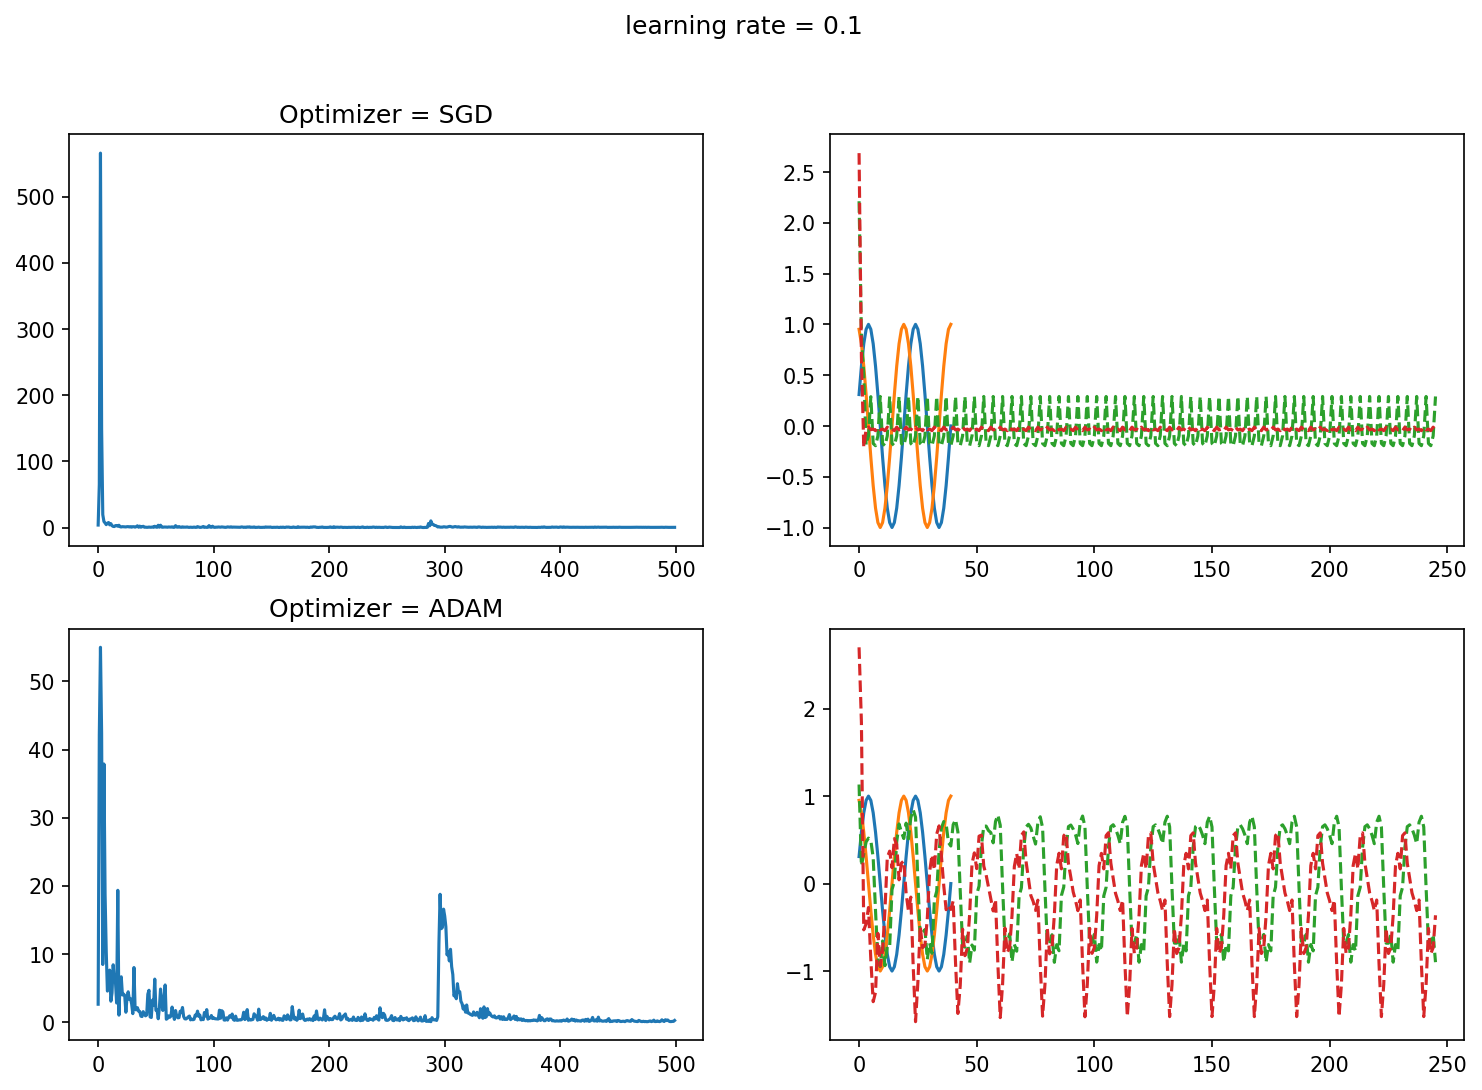

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

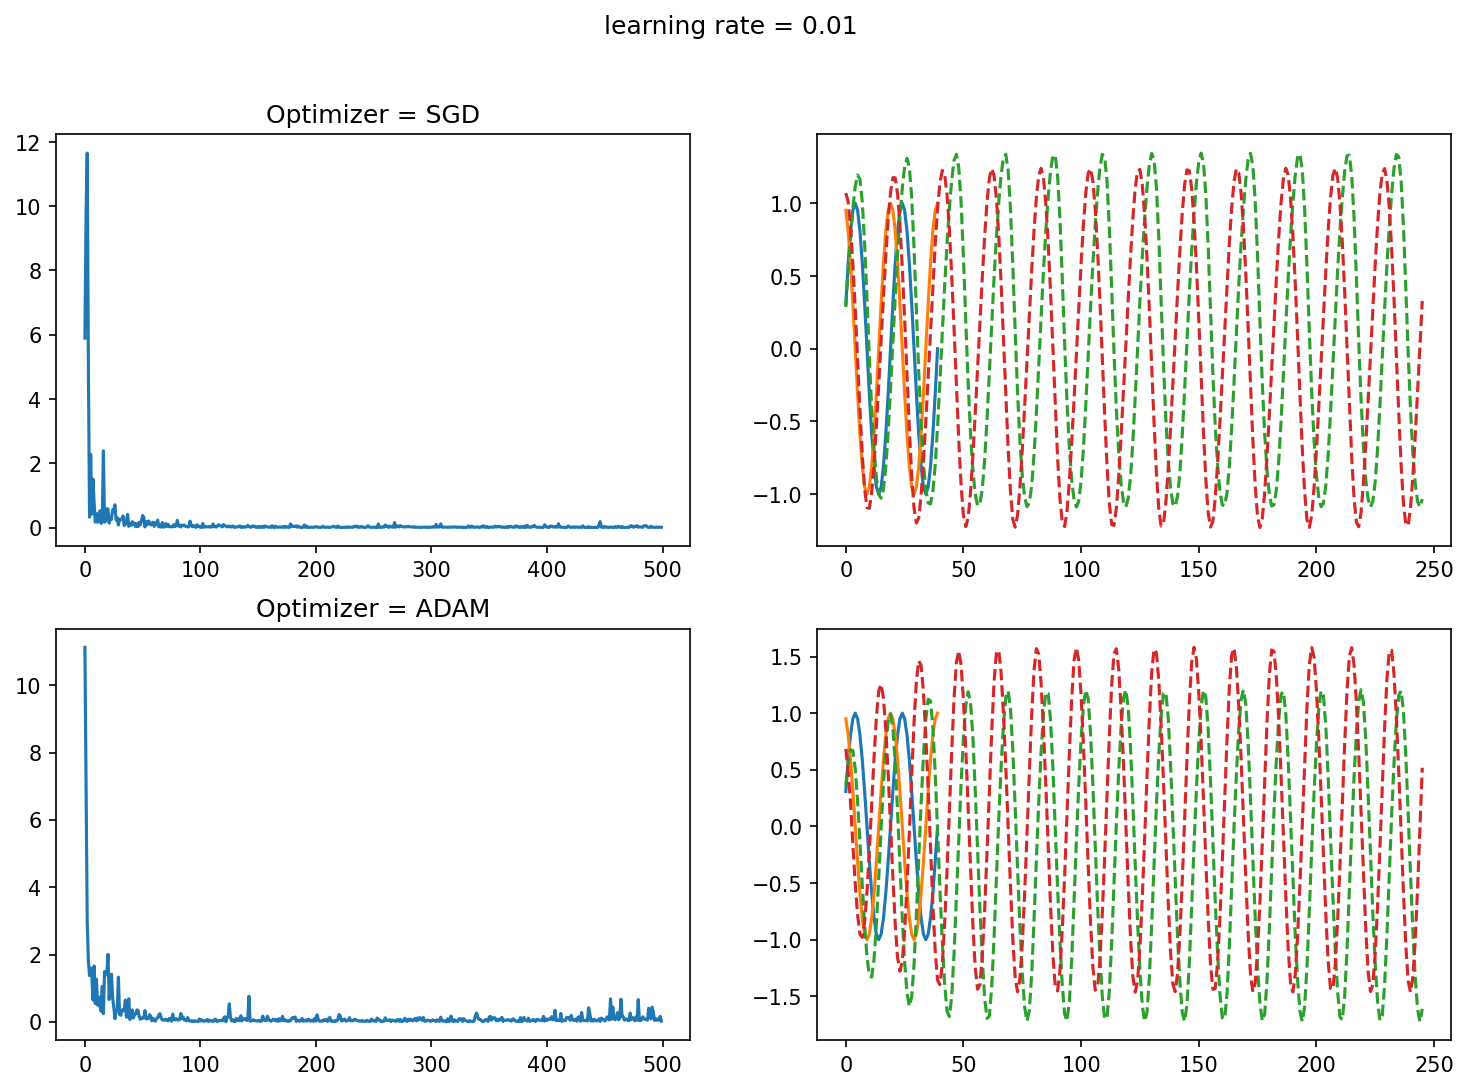

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

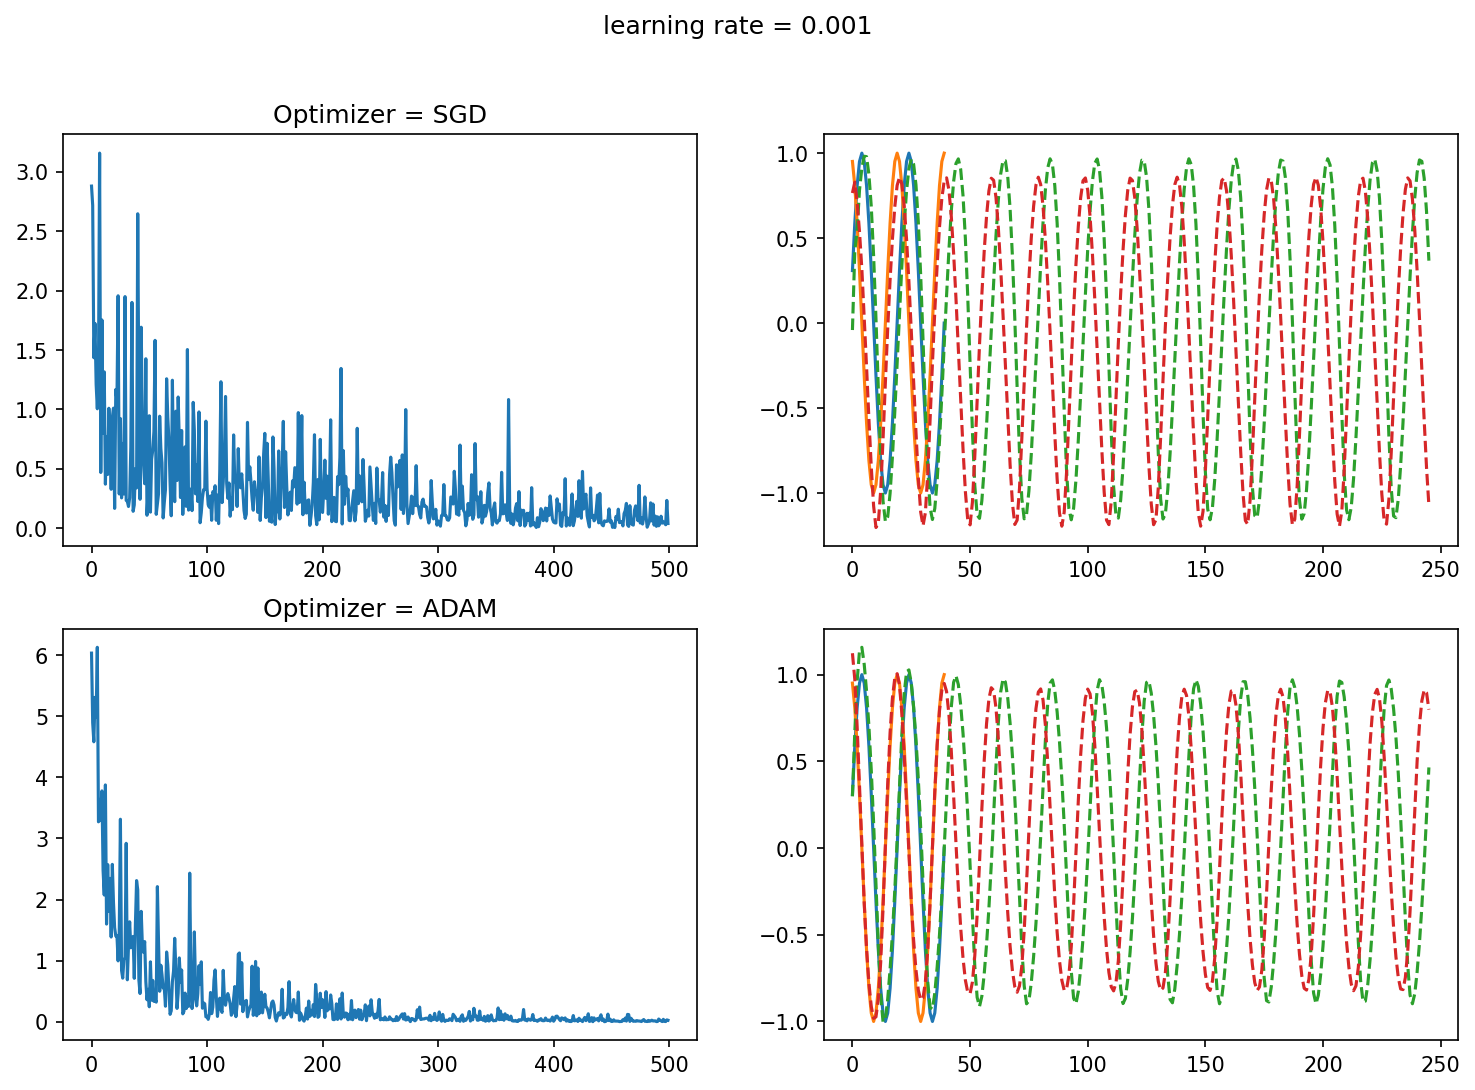

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

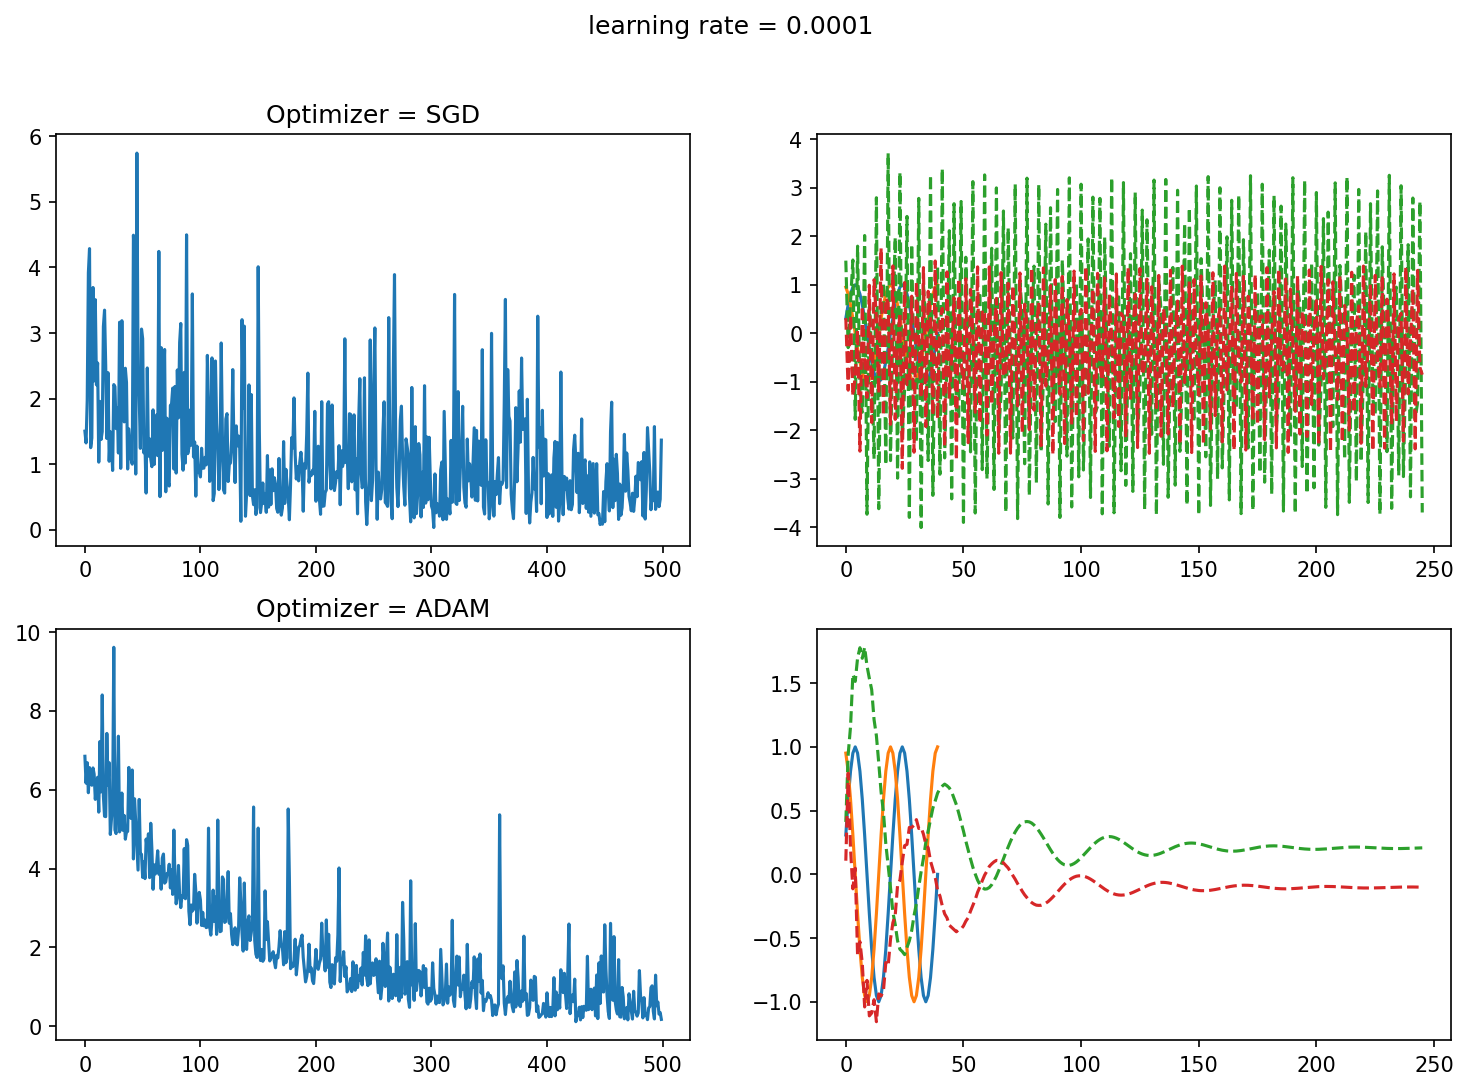

In [116]:
learning_rates = np.logspace(-1, -4, 4)
hidden_size = 20
epochs = 500
for learning_rate in learning_rates:
    fig, axes = plt.subplots(2, 2, figsize=(12,4*2))
    for j, (optimizer_name, optimizer_function) in enumerate(zip(["SGD", "ADAM"], [optim.SGD, optim.Adam])):
        model = latent_RNN(observation_size, hidden_size)
        optimizer = optimizer_function(model.parameters(), lr=learning_rate)
        loss_function = nn.MSELoss()

        losses = train(model, optimizer, loss_function, epochs, hidden_size)

        axes[j, 0].plot(losses)

        with torch.no_grad():
            h = torch.zeros((1, hidden_size))
            predictions = torch.zeros((6*data.shape[0], observation_size))
            input_ = data[0:1]
            for i in range(6*data.size(0)):
                pred, h = model(input_, h)
                input_ = pred
                predictions[i] = pred

            axes[j, 1].plot(data[1:])
            axes[j, 1].plot(predictions, "--")
    
        axes[j, 0].set_title(f"Optimizer = {optimizer_name}")

    fig.suptitle(f"learning rate = {learning_rate}")
    plt.show()

For lr=0.1 the ADAM optimizer seems to converge to better results than SGD. For lr=0.01 the result of ADAM is a bit worse than with SGD. For SGD's optimal learning rate 0.001, both results are equally good, but ADAM converges slightly faster. For lr=1e-4, both optimizer cannot converge within 500 epochs.

## Task 4

  0%|          | 0/500 [00:00<?, ?it/s]

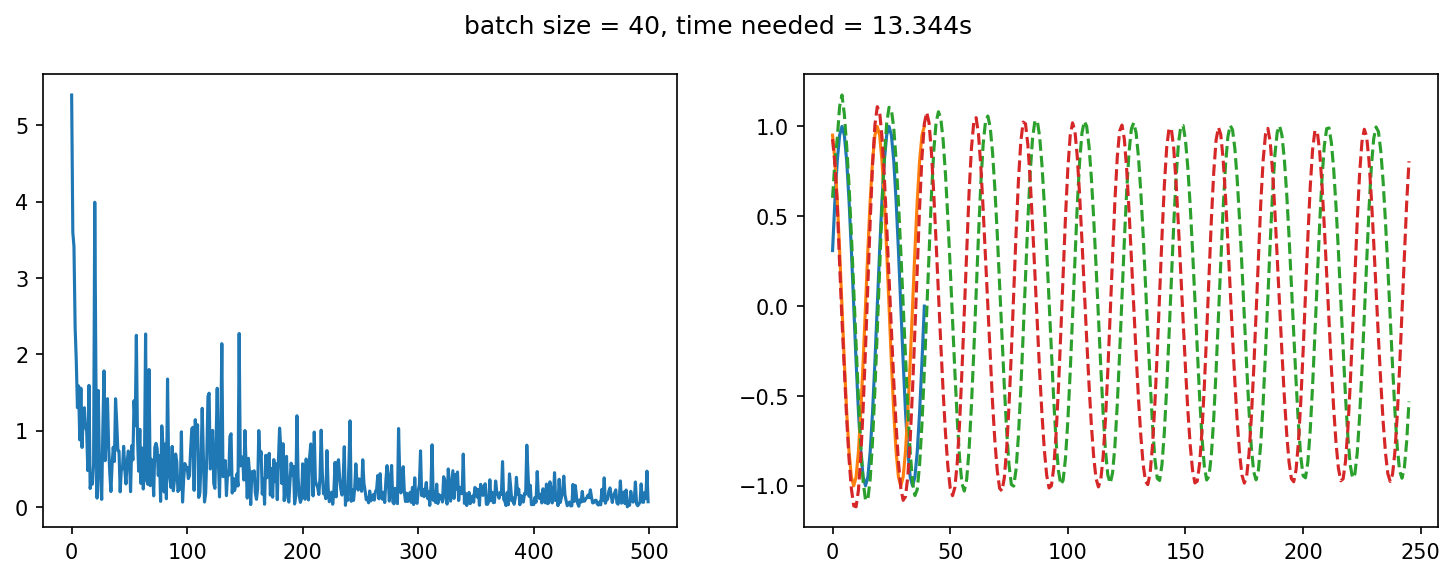

  0%|          | 0/500 [00:00<?, ?it/s]

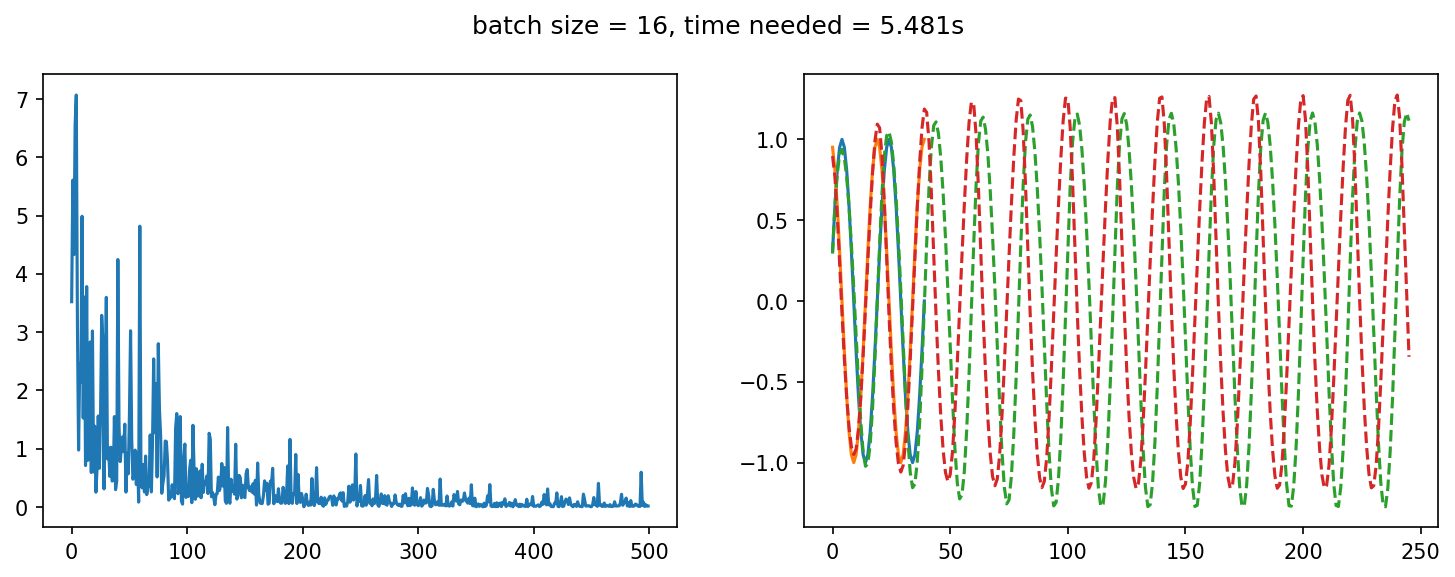

  0%|          | 0/500 [00:00<?, ?it/s]

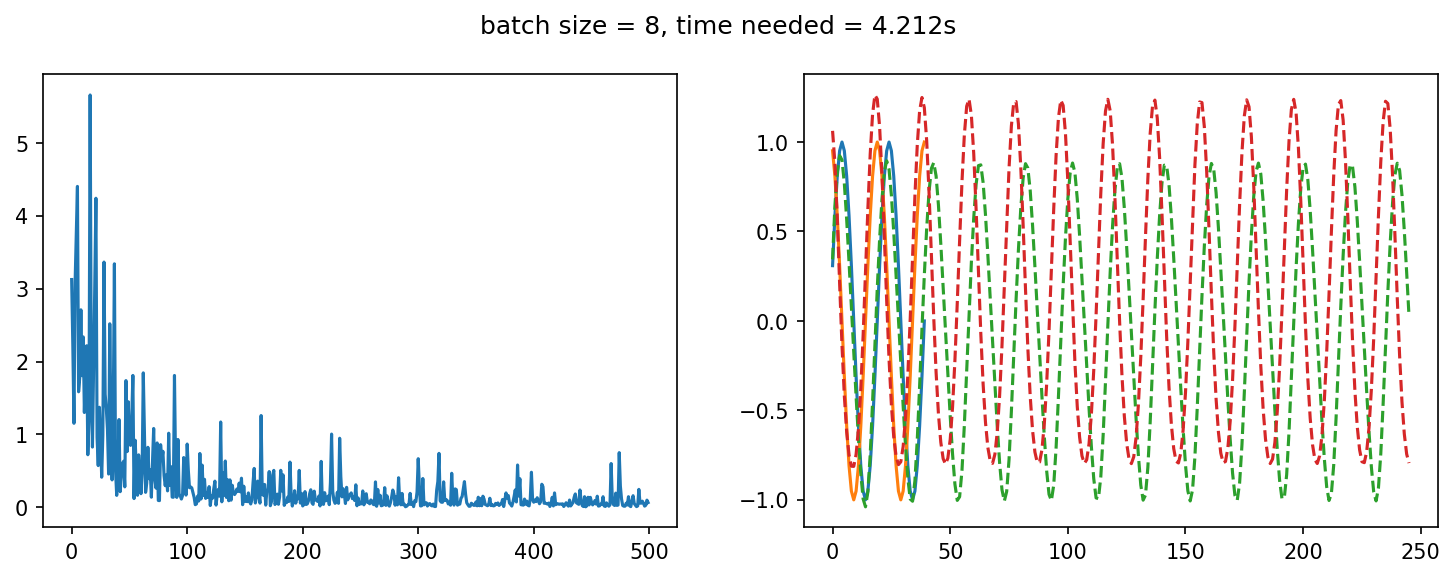

  0%|          | 0/500 [00:00<?, ?it/s]

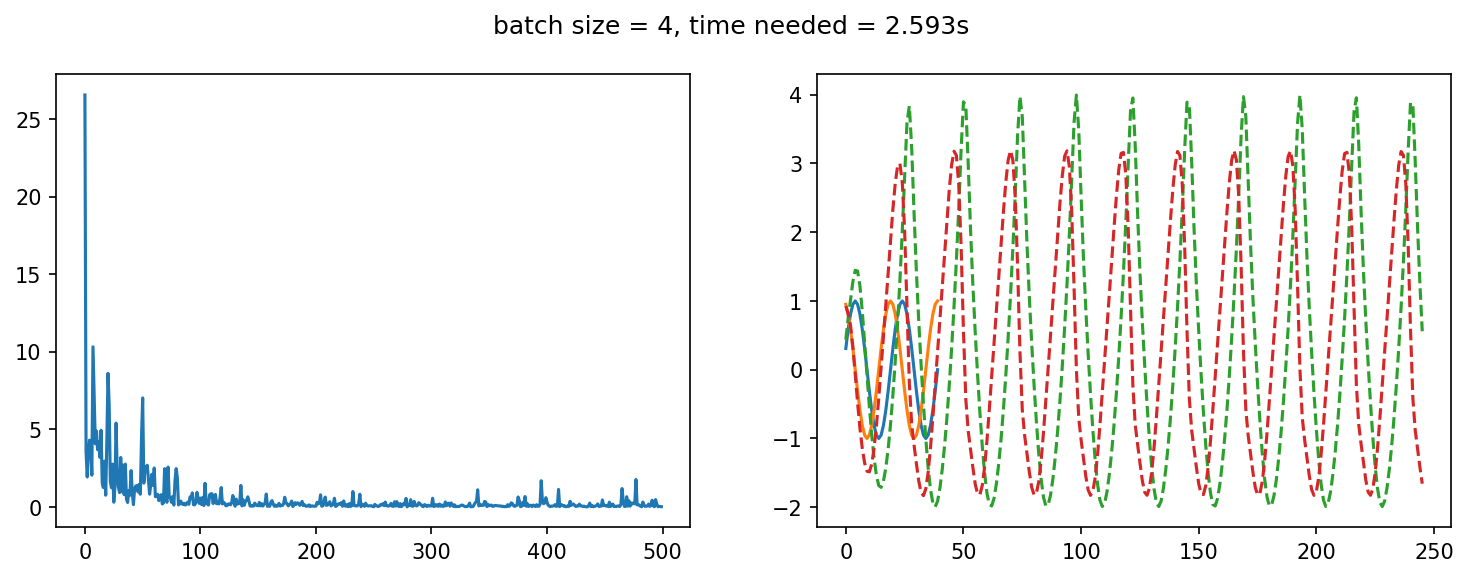

In [124]:
hidden_size = 20
epochs = 500
learning_rate = 1e-3
batch_sizes = [40, 16, 8, 4]
for batch_size in batch_sizes:
    model = latent_RNN(observation_size, hidden_size)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
    loss_function = nn.MSELoss()

    start = time.perf_counter()
    losses = train(model, optimizer, loss_function, epochs, hidden_size, batch_size=batch_size)
    time_needed = time.perf_counter() - start
    
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    axes[0].plot(losses)
    
    with torch.no_grad():
        h = torch.zeros((1, hidden_size))
        predictions = torch.zeros((6*data.shape[0], observation_size))
        input_ = data[0:1]
        for i in range(6*data.size(0)):
            pred, h = model(input_, h)
            input_ = pred
            predictions[i] = pred

        axes[1].plot(data[1:])
        axes[1].plot(predictions, "--")

    plt.suptitle(f"batch size = {batch_size}, time needed = {time_needed:.3f}s")
        
    plt.show()

As expected, for a smaller batch size it will need less time and less epochs to converge, but if the batch size is too small, it will not give as good results